# Imports

In [1]:
import os
import pathlib
import time
import skimage
import pandas as pd
import numpy as np
import mlflow
import mlflow.data
import cv2
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
import scipy.stats as stats
import tensorflow as tf
from tensorflow import keras
import warnings
from typing import List, Dict, Union, Tuple, Literal
from functools import reduce


warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='mlflow.models.model')

RANDOM_STATE = 0

2024-11-02 15:14:13.524187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 15:14:13.621856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 15:14:13.652517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 15:14:13.817018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 15:14:16.194678: W tensorflow/compiler/tf2

# Exploration

### Functions

In [ ]:
class ImageLoader(BaseEstimator, TransformerMixin):
    def __init__(self, resize=(64, 128)) -> None:
        self.resize = resize

    def load_image(self, image_path, resize):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(img, resize)
        return resized_img
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self.load_image(path, self.resize) for path in X])
    

class HOGFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, pixels_per_cell, cells_per_block, n_bins) -> None:
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.n_bins = n_bins

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array(
            [
                skimage.feature.hog(
                    img, 
                    orientations=self.n_bins, 
                    pixels_per_cell=self.pixels_per_cell, 
                    cells_per_block=self.cells_per_block
                ) for img in X
            ]
        )
        


def create_feature_extraction_pipeline(hog_params: Dict) -> Pipeline:
    return Pipeline(
        [
            ("Load images", ImageLoader()), 
            (
                "Extract HOG feature vector", 
                HOGFeatureExtractor(
                    pixels_per_cell=hog_params["pixels_per_cell"], 
                    cells_per_block=hog_params["cells_per_block"], 
                    n_bins=hog_params["n_bins"]
                )
            )
        ]
    )


def extract_features(image_paths: List, hog_params: Dict):
    pipeline = create_feature_extraction_pipeline(hog_params)
    features = pipeline.transform(image_paths)

    return features


# def train_svm(X_train, y_train, params):
#     model = GridSearchCV(SVC(), param_grid=params, n_jobs=2)
#     model.fit(X_train, y_train)

#     return model.best_estimator_


# def train_classifier(X_train, y_train, classifier, params):
#     model = GridSearchCV(classifier, param_grid=params, n_jobs=2)
#     model.fit(X_train, y_train)

#     return model.best_estimator_


# def train_and_score_model(classifier, test_df, pixels_per_cell, cells_per_block, num_samples, classifier_name):
#     """
#     Train a classifier on different HOG feature vectors. Then
#     generate predictions on the test set to get the accuracy 
#     score for each model to understand which HOG feature vector 
#     works best for this classifier type.
#     """
#     TRAIN_FEATURES_DIR = "object_recognition_data/playing_cards/train_hog_features"
#     MODEL_SAVE_DIR = f"object_recognition_data/playing_cards/models/{classifier_name}_hog"

#     pathlib.Path(MODEL_SAVE_DIR).mkdir(parents=True, exist_ok=True)


#     for pixel_count in pixels_per_cell:
#         for cell_count in cells_per_block:
#             train_data_name = f"hog_pixels{pixel_count[0]}_cells{cell_count[0]}.parquet"
#             train_data_path = os.path.join(TRAIN_FEATURES_DIR, train_data_name)
#             df = pd.read_parquet(train_data_path)

#             print(f"----- [Pixel Count: {pixel_count}, Cell Count: {cell_count}] -----")

#             for n in num_samples:
#                 with mlflow.start_run():
#                     # Sample the dataset for n data points from each 
#                     # card type and then shuffle the dataset
#                     subset = df.groupby(
#                         "labels"
#                     ).apply(
#                         lambda x: x.sample(n, random_state=RANDOM_STATE)
#                     ).sample(
#                         frac=1, random_state=RANDOM_STATE
#                     ).reset_index(drop=True)

#                     # Log the training set
#                     train_samples = subset[["filepaths", "labels"]]
#                     train_samples_path = os.path.join(
#                         MODEL_SAVE_DIR, 
#                         f"train_{train_data_name}"
#                     )
#                     train_samples.to_csv(train_samples_path, index=False)
#                     mlflow.log_artifact(train_samples_path)
                    
#                     mlflow.log_input(
#                         mlflow.data.from_pandas(train_samples),
#                         context="training samples"
#                     )

#                     # Train the model
#                     X_train = subset.drop(columns=["filepaths", "labels"])
#                     y_train = subset["labels"]
#                     tic = time.perf_counter()
#                     classifier.fit(X_train, y_train)
#                     toc = time.perf_counter()

#                     mlflow.log_metric("training_time", round(toc - tic, 2))

#                     # Explicitly deleting here to free up RAM
#                     del X_train

#                     # Save the model
#                     model_name = f"{classifier_name}_pixels{pixel_count[0]}_cells{cell_count[0]}_{n}samples"
#                     mlflow.sklearn.save_model(
#                         classifier, 
#                         os.path.join(MODEL_SAVE_DIR, model_name), 
#                         serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE
#                     )
#                     mlflow.sklearn.log_model(
#                         classifier, 
#                         os.path.join(MODEL_SAVE_DIR, model_name)
#                     )
                    
#                     # ----- Test pipeline -----
#                     hog_params = {
#                         "pixels_per_cell": pixel_count, 
#                         "cells_per_block": cell_count, 
#                         "n_bins": 9
#                     }

#                     X_test = extract_features(test_df["filepaths"].to_list(), hog_params=hog_params)
#                     y_test = test_df["labels"]

#                     tic = time.perf_counter()
#                     y_pred = classifier.predict(X_test)
#                     toc = time.perf_counter()

#                     mlflow.log_metric("inference_time", round(toc - tic, 2))

#                     accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
#                     mlflow.log_params(hog_params)
#                     mlflow.log_param("num_samples", n)
#                     mlflow.log_metric("accuracy", round(accuracy, 4))

#                 print(f"Completed {n} samples.")
#             print()


def create_model_save_directory(classifier_name: str) -> str:
    """Create a directory to save the models."""
    model_save_dir = f"object_recognition_data/playing_cards/models/{classifier_name}_hog"
    pathlib.Path(model_save_dir).mkdir(parents=True, exist_ok=True)
    return model_save_dir


def load_training_data(train_data_name: str) -> pd.DataFrame:
    """Load training data based on pixel and cell counts."""
    train_data_path = os.path.join("object_recognition_data/playing_cards/train_hog_features", train_data_name)
    return pd.read_parquet(train_data_path)


def sample_dataset(df: pd.DataFrame, n_samples: int) -> pd.DataFrame:
    """Sample a dataset with a specified number of samples per class and shuffle."""
    if n_samples == -1:
        n_samples = len(df)
    subset = df.groupby(
        "labels"
        ).apply(
            lambda x: x.sample(n_samples, random_state=RANDOM_STATE)
        ).sample(
            frac=1, random_state=RANDOM_STATE
        ).reset_index(drop=True)
    return subset


def format_data(features: pd.DataFrame, num_samples=-1):
    """
    Format the dataframe for training or scoring the neural network.

    If num_samples = -1, then use all the samples provided in samples. 
    Else, sample the dataframe for those many data points. 
    """
    features = features.copy()

    suits = features["labels"].apply(lambda y: y.split()[-1])
    features.insert(1, "suit", suits)
    numbers = features["labels"].apply(lambda y: y.split()[0])
    features.insert(2, "number", numbers)
    
    # if num_samples > 0:
    #     features = features.groupby(
    #         ["number", "suit"]
    #     ).sample(
    #         n=num_samples, random_state=RANDOM_STATE
    #     )

    return features.drop(columns="labels") # .sample(frac=1).reset_index(drop=True)


def log_training_samples(subset: pd.DataFrame, model_save_dir: str, train_data_name: str) -> None:
    """Log training samples as a CSV file."""
    train_samples = subset[["filepaths", "labels"]]
    train_samples_path = os.path.join(model_save_dir, f"train_{train_data_name}")
    train_samples.to_csv(train_samples_path, index=False)
    mlflow.log_artifact(train_samples_path)
    mlflow.log_input(mlflow.data.from_pandas(train_samples), context="training samples")


def train_classifier(classifier: BaseEstimator, X_train: pd.DataFrame | np.ndarray, y_train: pd.DataFrame | pd.Series | np.ndarray) -> BaseEstimator:
    """Train the classifier and log training time."""
    tic = time.perf_counter()
    classifier.fit(X_train, y_train)
    toc = time.perf_counter()
    mlflow.log_metric("training_time", round(toc - tic, 2))
    return classifier


def save_model(classifier: BaseEstimator, model_save_dir: str, classifier_name: str, pixel_count: int, cell_count: int, n_samples: int) -> None:
    """Save the trained model using MLflow."""
    model_name = f"{classifier_name}_pixels{pixel_count}_cells{cell_count}_{n_samples}samples"
    mlflow.sklearn.save_model(
        classifier, 
        os.path.join(model_save_dir, model_name), 
        serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE
    )
    mlflow.sklearn.log_model(
        classifier, 
        os.path.join(model_save_dir, model_name)
    )


def evaluate_classifier(classifier: BaseEstimator, test_df: pd.DataFrame, pixel_count: Tuple[int, int], cell_count: Tuple[int, int], pca_model=None) -> Dict[str, float]:
    """Evaluate the classifier and log accuracy and inference time."""
    hog_params = {
        "pixels_per_cell": pixel_count, 
        "cells_per_block": cell_count, 
        "n_bins": 9
    }
    X_test = extract_features(test_df["filepaths"].to_list(), hog_params=hog_params)
    y_test = test_df["labels"]

    if pca_model:
        X_test = pca_model.transform(X_test)

    tic = time.perf_counter()
    y_pred = classifier.predict(X_test)
    toc = time.perf_counter()
    mlflow.log_metric("inference_time", round(toc - tic, 2))

    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    precision, recall, fscore, support = precision_recall_fscore_support(
        y_true=y_test, 
        y_pred=y_pred, 
        average="macro"
    )

    metrics = {
        "accuracy": round(accuracy, 4), 
        "precision_macro": round(float(precision), 4) if precision else -1, 
        "recall_macro": round(float(recall), 4) if recall else -1, 
        "f1score_macro": round(float(fscore), 4) if fscore else -1, 
        "support_macro": round(float(support), 4) if support else -1
    }

    mlflow.log_params(hog_params)
    mlflow.log_metrics(metrics)

    return metrics


# @notify_on_completion
def train_and_score_model(
        classifier: BaseEstimator, 
        reduce_dimensions: bool, 
        test_df: pd.DataFrame, 
        pixels_per_cell: List[Tuple[int, int]], 
        cells_per_block: List[Tuple[int, int]], 
        num_samples: int, 
        classifier_name: str
):
    """Train a classifier on different HOG feature vectors and evaluate its performance."""
    model_save_dir = create_model_save_directory(classifier_name)

    models = {}

    for pixel_count in pixels_per_cell:
        for cell_count in cells_per_block:
            train_data_name = f"hog_pixels{pixel_count[0]}_cells{cell_count[0]}.parquet"
            df = load_training_data(train_data_name)

            print(f"----- [Pixel Count: {pixel_count}, Cell Count: {cell_count}] -----")

            for n in num_samples:
                with mlflow.start_run():
                    # subset = sample_dataset(df, n)
                    log_training_samples(subset, model_save_dir, f"hog_pixels{pixel_count[0]}_cells{cell_count[0]}.parquet")

                    subset = format_data(df)

                    X_train = subset.drop(columns=["filepaths", "labels"])
                    y_train = subset["labels"]

                    pca = None
                    if reduce_dimensions:
                        pca = PCA(n_components=0.96, random_state=RANDOM_STATE)
                        X_train = pca.fit_transform(X_train)

                    model = train_classifier(classifier, X_train, y_train)
                    save_model(classifier, model_save_dir, classifier_name, pixel_count[0], cell_count[0], n)

                    metrics = evaluate_classifier(classifier, test_df, pixel_count, cell_count, pca_model=pca)

                    models[f"pixels{pixel_count[0]}_cells{cell_count[0]}_{n}samples"] = {
                        "model": model, 
                        "metrics": metrics
                    }

                print(f"Completed {n} samples.")
            print()

    return models



# def run_feature_extraction(image_paths: list, batch_size, phase: str):
#     pixels_per_cell = [(4, 4), (8, 8), (16, 16)]
#     cells_per_block = [(2, 2), (3, 3), (4, 4)]
#     n_bins = 9

#     for pixel_count in pixels_per_cell:
#         for cell_count in cells_per_block:
#             hog_params = {
#                 "pixels_per_cell": pixel_count, 
#                 "cells_per_block": cell_count, 
#                 "n_bins": n_bins
#             }

#             pipeline = create_feature_extraction_pipeline(hog_params=hog_params)

#             with mlflow.start_run():
#                 # Split the data into batches of size batch_size
#                 batches = {
#                     str(i): image_paths[batch_size * i: batch_size * (i + 1)]
#                     for i in range(len(int(len(image_paths//batch_size + 1))))
#                 }

#                 for batch_number, data in batches.items():
#                     try:
#                         features = pipeline.transform(image_paths)
#                         features_df = pd.concat([pd.DataFrame(image_paths, columns=["paths"]), pd.DataFrame(features)], axis=1)

#                         file_name = f"object_recognition_data/playing_cards/hog_features_{phase}/hog_features_{phase}{label}_pixels{pixel_count[0]}_cells{cell_count[0]}.parquet"
#                         features_df.to_parquet(file_name, index=False)

#                         mlflow.log_params(hog_params)
#                         mlflow.log_artifact(file_name)

#                     except Exception as e:
#                         print(f"Could not extract features for pixel count {pixel_count} and cell count {cell_count}.")
#                         print(e)

#     return True    



def get_runs(experiment_name):
    df = mlflow.search_runs(experiment_names=[experiment_name])

    col_types = ["run_id", "metrics", "params"]
    valid_cols = []

    for col in df.columns:
        for ct in col_types:
            if col.startswith(ct):
                valid_cols.append(col)

    return df[valid_cols]
    

In [10]:
metadata = pd.read_csv("object_recognition_data/playing_cards/cards.csv")
metadata["filepaths"] = "object_recognition_data/playing_cards/" + metadata["filepaths"]
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class index  8154 non-null   int64 
 1   filepaths    8154 non-null   object
 2   labels       8154 non-null   object
 3   card type    8154 non-null   object
 4   data set     8154 non-null   object
dtypes: int64(1), object(4)
memory usage: 318.6+ KB


In [11]:
data_split = {
    "train": metadata[metadata["data set"] == "train"], 
    "valid": metadata[metadata["data set"] == "valid"], 
    "test": metadata[metadata["data set"] == "test"]
}

In [12]:
# # TODO: Uncomment file path logging
# # TODO: Set up multiprocessing for feature extraction.

# mlflow.set_experiment("HOG Feature Extraction")

# pixels_per_cell = [(8, 8), (16, 16)]
# cells_per_block = [(2, 2), (3, 3), (4, 4)]


# for phase, df in data_split.items():
#     print(f"----- {phase.upper()} DATA -----")
#     for pixel_count in pixels_per_cell:
#         for cell_count in cells_per_block:
#             hog_params = {
#                 "pixels_per_cell": pixel_count, 
#                 "cells_per_block": cell_count, 
#                 "n_bins": 9
#             }

#             with mlflow.start_run():
#                 features = extract_features(df["filepaths"].to_list(), hog_params=hog_params)
#                 features_df = pd.concat([df[["filepaths", "labels"]], pd.DataFrame(features)], axis=1)

#                 hog_features_dir = f"object_recognition_data/playing_cards/{phase}_hog_features"
#                 filename = f"hog_pixels{pixel_count[0]}_cells{cell_count[0]}.parquet"
                
#                 filepath = os.path.join(hog_features_dir, filename)
#                 features_df.to_parquet(filepath, index=False)

#                 mlflow.log_params(hog_params)
#                 # mlflow.log_artifact(filepath)
#                 # mlflow.log_param("filepath", filepath)

#                 print(f"Extracted. [Pixel count: {pixel_count}, Cell count: {cell_count}]")

#     print()

## Support Vector Classifier

### Initial Exploration

In [35]:
import mlflow.data.pandas_dataset


mlflow.set_experiment("Support Vector Classifier (HOG)")

svm_params = {
    "C": [0.1, 1, 10], 
    "kernel": ["linear"], 
    "gamma": ["scale", "auto", 0.01, 0.001]
}

pixels_per_cell = [(8, 8)]
cells_per_block = [(2, 2), (3, 3)]

num_samples = [5, 10, 20, 50]
train_features_dir = "object_recognition_data/playing_cards/train_hog_features"
model_save_dir = "object_recognition_data/playing_cards/models/support_vector_classifier_hog"

for pixel_count in pixels_per_cell:
    for cell_count in cells_per_block:
        train_data_name = f"hog_pixels{pixel_count[0]}_cells{cell_count[0]}.parquet"
        train_data_path = os.path.join(train_features_dir, train_data_name)
        df = pd.read_parquet(train_data_path)

        print(f"----- [Pixel Count: {pixel_count}, Cell Count: {cell_count}] -----")

        for n in num_samples:
            with mlflow.start_run():
                # Sample the dataset for n data points from each 
                # card type and then shuffle the dataset
                subset = df.groupby(
                    "labels"
                ).apply(
                    lambda x: x.sample(n, random_state=RANDOM_STATE)
                ).sample(
                    frac=1, random_state=RANDOM_STATE
                ).reset_index(drop=True)

                # Log the training set
                train_samples = subset[["filepaths", "labels"]]
                train_samples_path = os.path.join(
                    model_save_dir, 
                    f"train_{train_data_name}"
                )
                train_samples.to_csv(train_samples_path, index=False)
                mlflow.log_artifact(train_samples_path)
                
                mlflow.log_input(
                    mlflow.data.from_pandas(train_samples),
                    context="training samples"
                )

                # Train the model
                X_train = subset.drop(columns=["filepaths", "labels"])
                y_train = subset["labels"]
                tic = time.perf_counter()
                model = train_svm(X_train, y_train, params=svm_params)
                toc = time.perf_counter()

                mlflow.log_metric("training_time", round(toc - tic, 2))

                # Explicitly deleting here to free up RAM
                del X_train

                # Save the model
                model_name = f"svm_pixels{pixel_count[0]}_cells{cell_count[0]}_{n}samples"
                mlflow.sklearn.save_model(
                    model, 
                    os.path.join(model_save_dir, model_name), 
                    serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE
                )
                mlflow.sklearn.log_model(
                    model, 
                    os.path.join(model_save_dir, model_name)
                )
                
                # ----- Test pipeline -----
                hog_params = {
                    "pixels_per_cell": pixel_count, 
                    "cells_per_block": cell_count, 
                    "n_bins": 9
                }

                X_test = extract_features(data_split["test"]["filepaths"].to_list(), hog_params=hog_params)
                y_test = data_split["test"]["labels"]

                tic = time.perf_counter()
                y_pred = model.predict(X_test)
                toc = time.perf_counter()

                mlflow.log_metric("inference_time", round(toc - tic, 2))

                accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
                mlflow.log_params(hog_params)
                mlflow.log_param("num_samples", n)
                mlflow.log_metric("accuracy", round(accuracy, 4))

            print(f"Completed {n} samples.")
            print()
            

----- [Pixel Count: (8, 8), Cell Count: (2, 2)] -----


2024/10/09 17:36:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.



2024/10/09 17:37:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.



2024/10/09 17:39:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.



2024/10/09 17:50:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (8, 8), Cell Count: (3, 3)] -----


2024/10/09 17:51:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.



2024/10/09 17:52:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.



2024/10/09 17:56:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.



2024/10/09 18:38:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.



Downloaded the runs data from mlflow and saved it in "object_recognition_data/playing_cards/models/support_vector_classifier_hog"

### Finetuning

Random Search

In [17]:
svm_runs = get_runs("Support Vector Classifier (HOG)")
svm_runs.columns

Index(['run_id', 'metrics.inference_time', 'metrics.support_macro',
       'metrics.recall_macro', 'metrics.precision_macro',
       'metrics.f1score_macro', 'metrics.accuracy', 'metrics.training_time',
       'params.n_bins', 'params.pixels_per_cell', 'params.cells_per_block',
       'params.num_samples'],
      dtype='object')

In [20]:
svm_runs.sort_values(by="metrics.accuracy", ascending=False).head()

run_id  metrics.inference_time  \
2  fce4c33d2bfe45efabdc8460f477688a                    0.48   
8  ba94ec9b693a4ec39957544ffdb1254f                    2.39   
9  97acd2f0ddae4c7187d63cc59802b437                    3.39   
5  f6943c78c0a44a66921a9f711ff9f8b4                    0.68   
1  c93a3b4d6174411eb020ede986ce17d2                    1.16   

   metrics.support_macro  metrics.recall_macro  metrics.precision_macro  \
2                   -1.0                0.6075                   0.6344   
8                    NaN                   NaN                      NaN   
9                    NaN                   NaN                      NaN   
5                   -1.0                0.5962                   0.6237   
1                   -1.0                0.5962                   0.6260   

   metrics.f1score_macro  metrics.accuracy  metrics.training_time  \
2                 0.5980            0.6075                 519.80   
8                    NaN            0.6038                4968.96   
9                    NaN            0.6038                2435.37   
5                 0.5864            0.5962                 862.08   
1                 0.5889            0.5962                1190.86   

  params.n_bins params.pixels_per_cell params.cells_per_block  \
2             9               (16, 16)                 (4, 4)   
8             9                 (8, 8)                 (3, 3)   
9             9                 (8, 8)                 (3, 3)   
5             9               (16, 16)                 (4, 4)   
1             9               (16, 16)                 (3, 3)   

  params.num_samples  
2               None  
8                 50  
9                 50  
5               None  
1               None

In [9]:
mlflow.set_experiment("Support Vector Classifier (HOG)")


svm_param_grid = {
    "C": [1e-3, 1e-2, 1e-1, 1, 10, 100],
    "gamma": ["scale", "auto", 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 
    "degree": np.arange(2, 10), 
    "kernel": ["rbf", "linear", "poly"]
}

svm_random_search = train_and_score_model(
    RandomizedSearchCV(SVC(), svm_param_grid, n_iter=75, n_jobs=2), 
    test_df=data_split["test"], 
    pixels_per_cell=[(16, 16)], 
    cells_per_block=[(4, 4), (3, 3), (2, 2)], 
    num_samples=[50], 
    classifier_name="svm_finetuning"
)

----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


2024/10/26 21:40:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (3, 3)] -----


2024/10/26 22:00:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (2, 2)] -----


2024/10/26 22:17:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.



Grid Search for finding better hyperparameters

In [29]:
svm_best = mlflow.pyfunc.load_model("object_recognition_data/playing_cards/models/svm_finetuning_hog/svm_finetuning_pixels16_cells4_50samples")
svm_best

mlflow.pyfunc.loaded_model:
  flavor: mlflow.sklearn

In [40]:
svm_best.get_raw_model().best_estimator_.get_params()

{'C': 100,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 9,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [44]:
mlflow.set_experiment("Support Vector Classifier (HOG)")

svm_param_grid = {
    "C": np.arange(100, 300, 10), 
    "gamma": ["scale"], 
    "kernel": ["rbf"]
}

svm_grid_search = train_and_score_model(
    classifier=GridSearchCV(SVC(), svm_param_grid, n_jobs=2), 
    test_df=data_split["test"], 
    pixels_per_cell=[(16, 16)], 
    cells_per_block=[(4, 4)], 
    num_samples=[50], 
    classifier_name="svm_gridsearch"
)

----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


2024/10/28 16:25:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.



In [54]:
svm_grid_search["pixels16_cells4_50samples"]["model"].best_estimator_.get_params()

{'C': 100,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [66]:
svm_grid_search["pixels16_cells4_50samples"]

{'model': GridSearchCV(estimator=SVC(), n_jobs=2,
              param_grid={'C': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
        230, 240, 250, 260, 270, 280, 290]),
                          'gamma': ['scale'], 'kernel': ['rbf']}),
 'metrics': {'accuracy': 0.6075,
  'precision_macro': 0.6344,
  'recall_macro': 0.6075,
  'f1score_macro': 0.598,
  'support_macro': -1}}

In [55]:
svm_grid_search["pixels16_cells4_50samples"]["model"].best_estimator_

SVC(C=100)

In [56]:
mlflow.set_experiment("Support Vector Classifier (HOG)")

svm_param_grid = {
    "C": np.arange(80, 120, 5), 
    "gamma": ["scale"], 
    "kernel": ["rbf"]
}

svm_gridsearch2 = train_and_score_model(
    classifier=GridSearchCV(SVC(), svm_param_grid, n_jobs=2), 
    test_df=data_split["test"], 
    pixels_per_cell=[(16, 16)], 
    cells_per_block=[(4, 4)], 
    num_samples=[50], 
    classifier_name="svm_gridsearch2"
)

----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


2024/10/28 16:37:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.



In [59]:
svm_gridsearch2["pixels16_cells4_50samples"]# ["model"].best_estimator_.get_params()

{'model': GridSearchCV(estimator=SVC(), n_jobs=2,
              param_grid={'C': array([ 80,  85,  90,  95, 100, 105, 110, 115]),
                          'gamma': ['scale'], 'kernel': ['rbf']}),
 'metrics': {'accuracy': 0.6075,
  'precision_macro': 0.6344,
  'recall_macro': 0.6075,
  'f1score_macro': 0.598,
  'support_macro': -1}}

In [63]:
mlflow.set_experiment("Support Vector Classifier (HOG)")

svm_param_grid = {
    "C": np.arange(70, 90, 2), 
    "gamma": ["scale"], 
    "kernel": ["rbf"]
}

svm_gridsearch3 = train_and_score_model(
    classifier=GridSearchCV(SVC(), svm_param_grid, n_jobs=2), 
    test_df=data_split["test"], 
    pixels_per_cell=[(16, 16)], 
    cells_per_block=[(4, 4)], 
    num_samples=[50], 
    classifier_name="svm_gridsearch3"
)

----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


2024/10/28 16:47:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.



In [65]:
svm_gridsearch3["pixels16_cells4_50samples"]# ["model"].best_estimator_.get_params()

{'model': GridSearchCV(estimator=SVC(), n_jobs=2,
              param_grid={'C': array([70, 72, 74, 76, 78, 80, 82, 84, 86, 88]),
                          'gamma': ['scale'], 'kernel': ['rbf']}),
 'metrics': {'accuracy': 0.6038,
  'precision_macro': 0.6278,
  'recall_macro': 0.6038,
  'f1score_macro': 0.5936,
  'support_macro': -1}}

## Logistic Regression

### Initial Exploration

In [17]:
import mlflow.data.pandas_dataset


mlflow.set_experiment("Logistic Regression (HOG)")

logreg_param_grid = [
    {
        "solver": ["lbfgs", "newton-cg", "sag"],
        "penalty": ["l2", None], 
        "C": [0.1, 1, 10]
    }, 
    {
        "solver": ["saga"],
        "penalty": ["l1", "l2", "elasticnet", None], 
        "l1_ratio": [0.3, 0.6, 0.8],
        "C": [0.1, 1, 10]
    }
]

pixels_per_cell = [(8, 8)]
cells_per_block = [(2, 2), (3, 3), (4, 4)]

num_samples = [5, 10, 20, 50]
train_features_dir = "object_recognition_data/playing_cards/train_hog_features"
model_save_dir = "object_recognition_data/playing_cards/models/logistic_regression_hog"

for pixel_count in pixels_per_cell:
    for cell_count in cells_per_block:
        train_data_name = f"hog_pixels{pixel_count[0]}_cells{cell_count[0]}.parquet"
        train_data_path = os.path.join(train_features_dir, train_data_name)
        df = pd.read_parquet(train_data_path)

        print(f"----- [Pixel Count: {pixel_count}, Cell Count: {cell_count}] -----")

        for n in num_samples:
            with mlflow.start_run():
                # Sample the dataset for n data points from each 
                # card type and then shuffle the dataset
                subset = df.groupby(
                    "labels"
                ).apply(
                    lambda x: x.sample(n, random_state=RANDOM_STATE)
                ).sample(
                    frac=1, random_state=RANDOM_STATE
                ).reset_index(drop=True)

                # Log the training set
                train_samples = subset[["filepaths", "labels"]]
                train_samples_path = os.path.join(
                    model_save_dir, 
                    f"train_{train_data_name}"
                )
                train_samples.to_csv(train_samples_path, index=False)
                mlflow.log_artifact(train_samples_path)
                
                mlflow.log_input(
                    mlflow.data.from_pandas(train_samples),
                    context="training samples"
                )

                # Train the model
                X_train = subset.drop(columns=["filepaths", "labels"])
                y_train = subset["labels"]
                # Using the data configurations first to figure out which dataset to select.
                model = LogisticRegression()
                tic = time.perf_counter()
                # model = train_classifier(X_train, y_train, classifier=LogisticRegression(), params=logreg_param_grid)
                model.fit(X_train, y_train)
                toc = time.perf_counter()

                mlflow.log_metric("training_time", round(toc - tic, 2))

                # Explicitly deleting here to free up RAM
                del X_train

                # Save the model
                model_name = f"logreg_pixels{pixel_count[0]}_cells{cell_count[0]}_{n}samples"
                mlflow.sklearn.save_model(
                    model, 
                    os.path.join(model_save_dir, model_name), 
                    serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE
                )
                mlflow.sklearn.log_model(
                    model, 
                    os.path.join(model_save_dir, model_name)
                )
                
                # ----- Test pipeline -----
                hog_params = {
                    "pixels_per_cell": pixel_count, 
                    "cells_per_block": cell_count, 
                    "n_bins": 9
                }

                X_test = extract_features(data_split["test"]["filepaths"].to_list(), hog_params=hog_params)
                y_test = data_split["test"]["labels"]

                tic = time.perf_counter()
                y_pred = model.predict(X_test)
                toc = time.perf_counter()

                mlflow.log_metric("inference_time", round(toc - tic, 2))

                accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
                mlflow.log_params(hog_params)
                mlflow.log_param("num_samples", n)
                mlflow.log_metric("accuracy", round(accuracy, 4))

            print(f"Completed {n} samples.")
        print()
            

----- [Pixel Count: (8, 8), Cell Count: (2, 2)] -----


2024/10/11 14:01:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 14:01:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 14:01:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 14:02:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (8, 8), Cell Count: (3, 3)] -----


2024/10/11 14:02:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 14:02:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 14:03:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 14:03:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (8, 8), Cell Count: (4, 4)] -----


2024/10/11 14:04:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 14:04:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 14:04:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 14:05:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.



### Finetuning

In [68]:
logreg_runs = get_runs("Logistic Regression (HOG)")
logreg_runs.columns

Index(['run_id', 'metrics.inference_time', 'metrics.accuracy',
       'metrics.training_time', 'params.n_bins', 'params.pixels_per_cell',
       'params.num_samples', 'params.cells_per_block'],
      dtype='object')

In [70]:
logreg_runs.sort_values(by="metrics.accuracy", ascending=False)

run_id  metrics.inference_time  \
2   4a3089cf6f534283804d076bb5a3ec20                    0.01   
4   2e1fdb96fab146598613aaec8df831f9                    0.01   
1   85a595365ebd493686f5b691e5a57a5e                    0.00   
8   2a7a5ef155694bac80b4f0307f21453e                    0.00   
0   b75bde7f0b254a69a88ff1e4147adf95                    0.00   
12  3f20a4f13a0d4abf8780827bfaf88825                    0.00   
5   41190361d51d47cba88ba98ab3b6a600                    0.00   
24  1887a6956bc140438659e01f6ad15cdf                    0.00   
9   bf44fd15a32e43c3b2761c8ed3e14611                    0.01   
20  174819834edf46ddaa8d7f5df9876f40                    0.00   
16  5156ee67178e4bcaa41cc53a05c0d211                    0.00   
13  7c1d98d92dae44a18be9057156565a02                    0.00   
25  a91e3942d94040168e0ee377b51db231                    0.00   
21  f32f63d727a445beb36731a30f3efa26                    0.00   
6   df343da0b63e4072a0311daebd1970eb                    0.01   
17  faa4427ac0f64380a4d6e0e26c59234e                    0.00   
10  a9f787b10b30434da84e7a26014c406c                    0.00   
14  d9ad403267fe410cadac638ed0bc80a3                    0.00   
26  f1b19ed559444258ab73b55ff05c90af                    0.00   
22  be210ef5ff8448dd9cfb599b506a8f6b                    0.00   
11  e834f55b173947b1a22608868f742241                    0.00   
7   c628b48810414ef0915842c923be14be                    0.00   
18  d62cec816bfa418c9c07e79f2055906c                    0.00   
15  6b2d329a0068448b8a36813ee4f8f4d2                    0.00   
23  2da7159fce8d424c96e07639dc78a76d                    0.00   
27  d71543ba52d2471685b8e98d3d74b0f6                    0.00   
19  c923d0625fd84b7a80331edb194797bb                    0.00   
3   f3eac3f7c03442599eaa16fe9f5f3793                     NaN   

    metrics.accuracy  metrics.training_time params.n_bins  \
2             0.5925                 747.58             9   
4             0.5925                  20.12             9   
1             0.5887                 549.24             9   
8             0.5811                  12.81             9   
0             0.5434                 340.94             9   
12            0.5434                   7.90             9   
5             0.5358                   8.85             9   
24            0.5321                   2.00             9   
9             0.5321                   9.52             9   
20            0.5321                   2.89             9   
16            0.5283                   1.07             9   
13            0.4792                   3.79             9   
25            0.4566                   1.32             9   
21            0.4566                   1.88             9   
6             0.4302                   6.42             9   
17            0.4302                   0.55             9   
10            0.4264                   5.16             9   
14            0.4075                   2.22             9   
26            0.3698                   0.70             9   
22            0.3623                   0.63             9   
11            0.3585                   3.92             9   
7             0.3509                   5.49             9   
18            0.3208                   0.38             9   
15            0.3170                   1.88             9   
23            0.2830                   0.44             9   
27            0.2453                   0.60             9   
19            0.2340                   0.24             9   
3                NaN                    NaN          None   

   params.pixels_per_cell params.num_samples params.cells_per_block  
2                  (8, 8)                 50                 (4, 4)  
4                  (8, 8)                 50                 (4, 4)  
1                  (8, 8)                 50                 (3, 3)  
8                  (8, 8)                 50                 (3, 3)  
0                  (8, 8)                 50         

Choosing the top 3 runs (by accuracy) for further finetuning. 

In [74]:
mlflow.set_experiment("Logistic Regression (HOG)")

# logreg_param_grid = [
#     {
#         "solver": ["lbfgs", "newton-cg"], 
#         "penalty": ["l2", None], 
#         "C": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
#     }, 
#     {
#         "solver": ["saga"], 
#         "penalty": ["elastic_net", "l1", "l2", None], 
#         "l1_ratio": np.linspace(0, 1, 20), 
#         "C": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
#     }
# ]

logreg_param_grid = {
    "solver": ["lbfgs", "newton-cg"], 
    "penalty": ["l2", None], 
    "C": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
}

train_and_score_model(
    RandomizedSearchCV(LogisticRegression(), logreg_param_grid, n_jobs=2), 
    test_df=data_split["test"], 
    pixels_per_cell=[(16, 16)], 
    cells_per_block=[(4, 4), (3, 3), (2, 2)], 
    num_samples=[50], 
    classifier_name="logreg_randomsearch" 
)

----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/en

Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (3, 3)] -----


/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/en

Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (2, 2)] -----


/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/en

Completed 50 samples.



{'pixels16_cells4_50samples': {'model': RandomizedSearchCV(estimator=LogisticRegression(), n_jobs=2,
                     param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                1000],
                                          'penalty': ['l2', None],
                                          'solver': ['lbfgs', 'newton-cg']}),
  'metrics': {'accuracy': 0.5321,
   'precision_macro': 0.5741,
   'recall_macro': 0.5321,
   'f1score_macro': 0.5242,
   'support_macro': -1}},
 'pixels16_cells3_50samples': {'model': RandomizedSearchCV(estimator=LogisticRegression(), n_jobs=2,
                     param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                1000],
                                          'penalty': ['l2', None],
                                          'solver': ['lbfgs', 'newton-cg']}),
  'metrics': {'accuracy': 0.5283,
   'precision_macro': 0.5818,
   'recall_macro': 0.5283,
   'f1

In [75]:
mlflow.set_experiment("Logistic Regression (HOG)")


logreg_param_grid = {
    "solver": ["saga"], 
    "penalty": ["elastic_net", "l1", "l2", None], 
    "l1_ratio": np.linspace(0, 1, 20), 
    "C": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
}

logreg_randomsearch2 = train_and_score_model(
    RandomizedSearchCV(LogisticRegression(), logreg_param_grid, n_iter=50, n_jobs=2), 
    test_df=data_split["test"], 
    pixels_per_cell=[(16, 16)], 
    cells_per_block=[(4, 4), (3, 3), (2, 2)], 
    num_samples=[50], 
    classifier_name="logreg_randomsearch2" 
)

----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when pena

Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (3, 3)] -----


/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not

KeyboardInterrupt: 

Using PCA on the data since training is not converging and taking too long. 

In [2]:
data_16_2 = pd.read_parquet("object_recognition_data/playing_cards/train_hog_features/hog_pixels16_cells2.parquet")
data_16_2.shape

(7624, 758)

In [5]:
data_16_2.head()

filepaths        labels         0  \
0  object_recognition_data/playing_cards/train/ac...  ace of clubs  0.287212   
1  object_recognition_data/playing_cards/train/ac...  ace of clubs  0.293974   
2  object_recognition_data/playing_cards/train/ac...  ace of clubs  0.279561   
3  object_recognition_data/playing_cards/train/ac...  ace of clubs  0.324793   
4  object_recognition_data/playing_cards/train/ac...  ace of clubs  0.165444   

          1         2         3         4         5         6         7  ...  \
0  0.188653  0.287212  0.116148  0.178377  0.026057  0.116902  0.139051  ...   
1  0.062509  0.071085  0.187622  0.199516  0.117940  0.236594  0.190019  ...   
2  0.156214  0.279561  0.123984  0.279561  0.077248  0.279561  0.079596  ...   
3  0.253737  0.018726  0.058325  0.080143  0.020300  0.085623  0.212820  ...   
4  0.161420  0.181096  0.118025  0.224078  0.224078  0.224078  0.224078  ...   

        746       747       748       749       750       751       752  \
0  0.032975  0.007738  0.019318  0.116827  0.028899  0.011309  0.005286   
1  0.000571  0.274064  0.163660  0.046992  0.045868  0.050016  0.064486   
2  0.000000  0.283501  0.141105  0.222188  0.180741  0.283501  0.090565   
3  0.009121  0.317923  0.137246  0.119381  0.039495  0.236773  0.008257   
4  0.141101  0.196491  0.205457  0.110609  0.184673  0.222771  0.209018   

        753       754       755  
0  0.001913  0.003025  0.001859  
1  0.062829  0.192930  0.274064  
2  0.283501  0.194047  0.283501  
3  0.079038  0.172264  0.317923  
4  0.222771  0.222771  0.222771  

[5 rows x 758 columns]

(7624, 9362)

Number of components: 0.87, Shape: (7624, 122)
Number of components: 0.88, Shape: (7624, 131)
Number of components: 0.89, Shape: (7624, 140)
Number of components: 0.9, Shape: (7624, 150)
Number of components: 0.91, Shape: (7624, 161)
Number of components: 0.92, Shape: (7624, 174)
Number of components: 0.9299999999999999, Shape: (7624, 188)
Number of components: 0.94, Shape: (7624, 204)
Number of components: 0.95, Shape: (7624, 223)
Number of components: 0.96, Shape: (7624, 247)
Number of components: 0.97, Shape: (7624, 278)
Number of components: 0.98, Shape: (7624, 321)
Number of components: 0.99, Shape: (7624, 409)


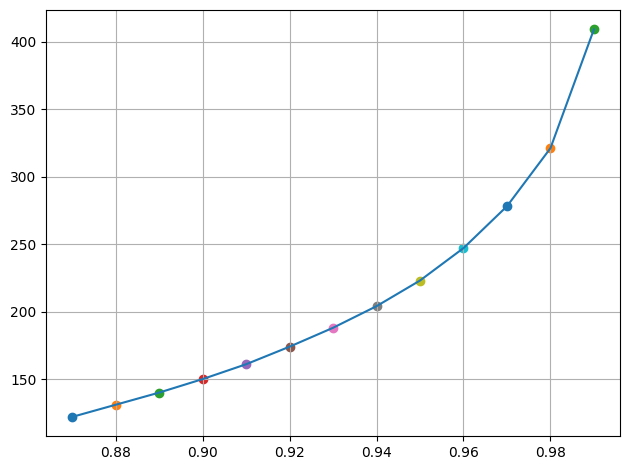

In [26]:
start = 0.87
end = 0.99
step = 0.01
num_elements = int((end - start) / step) + 1

fig, ax = plt.subplots()
vars = []
ncs = []

for nc in np.linspace(start, end, num_elements):
    pca = PCA(n_components=nc, random_state=RANDOM_STATE)
    data_16_2_reduced = pca.fit_transform(data_16_2.drop(columns=["filepaths", "labels"]))
    
    ax.scatter([nc], [data_16_2_reduced.shape[1]])
    vars.append(nc)
    ncs.append(data_16_2_reduced.shape[1])
    print(f"Number of components: {nc}, Shape: {data_16_2_reduced.shape}")

ax.plot(vars, ncs)
ax.grid()
plt.tight_layout()
plt.show()

Let's choose 96% as the ratio of explained variance for PCA. 

In [13]:
mlflow.set_experiment("Logistic Regression (HOG)")

#     {
#         "solver": ["saga"], 
#         "penalty": ["elastic_net", "l1", "l2", None], 
#         "l1_ratio": np.linspace(0, 1, 20), 
#         "C": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
#     }
# ]

logreg_param_grid = {
    "solver": ["lbfgs", "newton-cg"], 
    "penalty": ["l2", None], 
    "C": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
}

train_and_score_model(
    RandomizedSearchCV(LogisticRegression(), logreg_param_grid, n_jobs=2), 
    reduce_dimensions=True, 
    test_df=data_split["test"], 
    pixels_per_cell=[(16, 16)], 
    cells_per_block=[(4, 4), (3, 3), (2, 2)], 
    num_samples=[50], 
    classifier_name="logreg_randomsearch_pca1" 
)

----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/en

Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (3, 3)] -----


/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/en

Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (2, 2)] -----


/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/aryan/miniconda3/en

Completed 50 samples.



{'pixels16_cells4_50samples': {'model': RandomizedSearchCV(estimator=LogisticRegression(), n_jobs=2,
                     param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                1000],
                                          'penalty': ['l2', None],
                                          'solver': ['lbfgs', 'newton-cg']}),
  'metrics': {'accuracy': 0.5208,
   'precision_macro': 0.5457,
   'recall_macro': 0.5208,
   'f1score_macro': 0.5077,
   'support_macro': -1}},
 'pixels16_cells3_50samples': {'model': RandomizedSearchCV(estimator=LogisticRegression(), n_jobs=2,
                     param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                1000],
                                          'penalty': ['l2', None],
                                          'solver': ['lbfgs', 'newton-cg']}),
  'metrics': {'accuracy': 0.5132,
   'precision_macro': 0.5699,
   'recall_macro': 0.5132,
   'f1

In [14]:
mlflow.set_experiment("Logistic Regression (HOG)")


logreg_param_grid = {
    "solver": ["saga"], 
    "penalty": ["elastic_net", "l1", "l2", None], 
    "l1_ratio": np.linspace(0, 1, 20), 
    "C": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
}


logreg_randomsearch_pca2 = train_and_score_model(
    RandomizedSearchCV(LogisticRegression(), logreg_param_grid, n_iter=50, n_jobs=2), 
    reduce_dimensions=True, 
    test_df=data_split["test"], 
    pixels_per_cell=[(16, 16)], 
    cells_per_block=[(4, 4), (3, 3), (2, 2)], 
    num_samples=[50], 
    classifier_name="logreg_randomsearch_pca2" 
)

----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not

Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (3, 3)] -----


/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not

Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (2, 2)] -----


/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when pena

KeyboardInterrupt: 

Logistic regression doesn't seem to be performing well compared to SVC, and so we will not consider it for further experimentation. 

## Random Forest Classifier

### Initial Exploration

In [21]:
mlflow.set_experiment("Random Forest Classifier (HOG)")


pixels_per_cell = [(8, 8), (16, 16)]
cells_per_block = [(2, 2), (3, 3), (4, 4)]
num_samples = [5, 10, 20, 50]

model_save_dir = "object_recognition_data/playing_cards/models/random_forest_hog"


train_and_score_model(
    classifier=RandomForestClassifier(), 
    test_df=data_split["test"], 
    pixels_per_cell=pixels_per_cell, 
    cells_per_block=cells_per_block, 
    num_samples=num_samples, 
    model_save_dir=model_save_dir
)

2024/10/11 14:31:53 INFO mlflow.tracking.fluent: Experiment with name 'Random Forest Classifier (HOG)' does not exist. Creating a new experiment.


----- [Pixel Count: (8, 8), Cell Count: (2, 2)] -----


2024/10/11 14:32:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 14:32:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 14:32:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 14:33:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (8, 8), Cell Count: (3, 3)] -----


2024/10/11 14:34:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 14:34:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 14:35:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 14:36:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (8, 8), Cell Count: (4, 4)] -----


2024/10/11 14:36:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 14:37:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 14:37:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 14:38:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (2, 2)] -----


2024/10/11 14:39:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 14:39:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 14:39:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 14:40:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (3, 3)] -----


2024/10/11 14:40:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 14:40:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 14:41:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 14:41:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


2024/10/11 14:42:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 14:42:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 14:42:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 14:43:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.



### Finetuning

In [16]:
rf_runs = get_runs("Random Forest Classifier (HOG)")
rf_runs.sort_values(by="metrics.accuracy", ascending=False).head(10)

run_id  metrics.accuracy  metrics.training_time  \
13  12c3778f3499403e8da430c7b57e2dcb            0.5434                  48.90   
17  236350f87bcc4c9fb449ff2f013604a5            0.5245                  40.07   
5   461ad5b9d6244102ab6925b0f9bb49b0            0.4943                  13.46   
9   0e4a0478127548be8d9d7a79bf317793            0.4906                  14.58   
1   5d197c9bab134fbab4192895c43afe25            0.4679                  11.23   
21  c49df79c52f84969bb41d5847715e238            0.4642                  29.35   
6   11371abf429b4869afc3d2c19d7bd858            0.4151                   5.23   
14  1ada7e6f99fd4041843d3818a6e46e54            0.3925                  19.65   
2   7db288f9950a4d598f8acf7478f344be            0.3887                   4.34   
18  6f56a6ce010542969eb9a0131386482d            0.3849                  15.56   

    metrics.inference_time params.num_samples params.pixels_per_cell  \
13                    0.03                 50                 (8, 8)   
17                    0.03                 50                 (8, 8)   
5                     0.02                 50               (16, 16)   
9                     0.01                 50               (16, 16)   
1                     0.01                 50               (16, 16)   
21                    0.02                 50                 (8, 8)   
6                     0.01                 20               (16, 16)   
14                    0.02                 20                 (8, 8)   
2                     0.01                 20               (16, 16)   
18                    0.02                 20                 (8, 8)   

   params.n_bins params.cells_per_block  
13             9                 (4, 4)  
17             9                 (3, 3)  
5              9                 (3, 3)  
9              9                 (2, 2)  
1              9                 (4, 4)  
21             9                 (2, 2)  
6              9                 (3, 3)  
14             9                 (4, 4)  
2              9                 (4, 4)  
18             9                 (3, 3)

In [17]:
mlflow.set_experiment("Random Forest Classifier (HOG)")

rf_param_grid = {
    "n_estimators": np.arange(100, 1100, 100),
    "max_depth": [None, 10, 20, 30],              
    "min_samples_split": [2, 5, 10],              
    "min_samples_leaf": [1, 2, 4],                
    "max_features": ["sqrt", "log2", None],       
    "bootstrap": [True, False]                    
}


rf_randomsearch_1 = train_and_score_model(
    RandomizedSearchCV(RandomForestClassifier(), rf_param_grid, n_iter=50, n_jobs=2), 
    reduce_dimensions=False, 
    test_df=data_split["test"], 
    pixels_per_cell=[(16, 16)], 
    cells_per_block=[(4, 4), (3, 3), (2, 2)], 
    num_samples=[50], 
    classifier_name="rf_randomsearch1"
)

----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


KeyboardInterrupt: 

## LightGBM

In [23]:
mlflow.set_experiment("LightGBM (HOG)")


pixels_per_cell = [(8, 8), (16, 16)]
cells_per_block = [(2, 2), (3, 3), (4, 4)]
num_samples = [5, 10, 20, 50]

model_save_dir = "object_recognition_data/playing_cards/models/light_gbm_hog"


train_and_score_model(
    classifier=lgb.LGBMClassifier(), 
    test_df=data_split["test"], 
    pixels_per_cell=pixels_per_cell, 
    cells_per_block=cells_per_block, 
    num_samples=num_samples, 
    model_save_dir=model_save_dir
)

2024/10/11 14:54:53 INFO mlflow.tracking.fluent: Experiment with name 'LightGBM (HOG)' does not exist. Creating a new experiment.


----- [Pixel Count: (8, 8), Cell Count: (2, 2)] -----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282315
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 3780
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightG

2024/10/11 14:56:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558766
[LightGBM] [Info] Number of data points in the train set: 530, number of used features: 3780
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from sc

2024/10/11 15:00:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.269823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 948864
[LightGBM] [Info] Number of data points in the train set: 1060, number of used features: 3780
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from 

2024/10/11 15:08:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963896
[LightGBM] [Info] Number of data points in the train set: 2650, number of used features: 3780
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from 

2024/10/11 15:19:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (8, 8), Cell Count: (3, 3)] -----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 513997
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 6804
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from 

2024/10/11 15:22:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.256850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1015866
[LightGBM] [Info] Number of data points in the train set: 530, number of used features: 6804
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from s

2024/10/11 15:29:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1713256
[LightGBM] [Info] Number of data points in the train set: 1060, number of used features: 6804
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from

2024/10/11 15:43:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.594356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1735020
[LightGBM] [Info] Number of data points in the train set: 2650, number of used features: 6804
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from

2024/10/11 16:02:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (8, 8), Cell Count: (4, 4)] -----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 710260
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 9360
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from 

2024/10/11 16:05:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.460106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1403435
[LightGBM] [Info] Number of data points in the train set: 530, number of used features: 9360
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from s

2024/10/11 16:14:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.348892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2359708
[LightGBM] [Info] Number of data points in the train set: 1060, number of used features: 9360
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from

2024/10/11 16:32:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.714385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2386800
[LightGBM] [Info] Number of data points in the train set: 2650, number of used features: 9360
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from

2024/10/11 16:55:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (2, 2)] -----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64188
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 756
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from 

2024/10/11 16:55:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127200
[LightGBM] [Info] Number of data points in the train set: 530, number of used features: 756
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from sco

2024/10/11 16:56:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192780
[LightGBM] [Info] Number of data points in the train set: 1060, number of used features: 756
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from s

2024/10/11 16:58:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192780
[LightGBM] [Info] Number of data points in the train set: 2650, number of used features: 756
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from s

2024/10/11 17:00:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (3, 3)] -----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82516
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 972
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from 

2024/10/11 17:01:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163634
[LightGBM] [Info] Number of data points in the train set: 530, number of used features: 972
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from sco

2024/10/11 17:02:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 247860
[LightGBM] [Info] Number of data points in the train set: 1060, number of used features: 972
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from s

2024/10/11 17:04:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 247860
[LightGBM] [Info] Number of data points in the train set: 2650, number of used features: 972
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from s

2024/10/11 17:07:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60723
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 720
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from 

2024/10/11 17:07:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120562
[LightGBM] [Info] Number of data points in the train set: 530, number of used features: 720
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from sco

2024/10/11 17:08:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183600
[LightGBM] [Info] Number of data points in the train set: 1060, number of used features: 720
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from s

2024/10/11 17:09:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183600
[LightGBM] [Info] Number of data points in the train set: 2650, number of used features: 720
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from score -3.970292
[LightGBM] [Info] Start training from s

2024/10/11 17:11:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.



## k-Nearest Neighbours

In [34]:
mlflow.set_experiment("k-Nearest Neighbours (HOG)")


pixels_per_cell = [(8, 8), (16, 16)]
cells_per_block = [(2, 2), (3, 3), (4, 4)]
num_samples = [5, 10, 20, 50]



train_and_score_model(
    classifier=KNeighborsClassifier(), 
    test_df=data_split["test"], 
    pixels_per_cell=pixels_per_cell, 
    cells_per_block=cells_per_block, 
    num_samples=num_samples, 
    classifier_name="knn"
)

----- [Pixel Count: (8, 8), Cell Count: (2, 2)] -----


2024/10/11 18:36:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 18:37:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 18:37:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 18:37:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (8, 8), Cell Count: (3, 3)] -----


2024/10/11 18:38:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 18:38:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 18:38:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 18:39:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (8, 8), Cell Count: (4, 4)] -----


2024/10/11 18:39:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 18:40:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 18:40:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 18:41:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (2, 2)] -----


2024/10/11 18:41:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 18:41:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 18:41:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 18:42:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (3, 3)] -----


2024/10/11 18:42:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 18:42:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 18:42:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 18:43:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.

----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


2024/10/11 18:43:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 5 samples.


2024/10/11 18:43:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 10 samples.


2024/10/11 18:43:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 20 samples.


2024/10/11 18:44:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Completed 50 samples.



Taking inspiration from neural networks and their different "heads", let us break down the classification into 2 sub-problems: 
1. Classifying the suit 
2. Classifying the number

In [16]:
data = pd.read_parquet("object_recognition_data/playing_cards/train_hog_features/hog_pixels8_cells2.parquet")
data.shape

(7624, 3782)

In [19]:
data1 = format_data(data)

In [24]:
data2 = data1[(data1["suit"] != "joker") & (data1["number"] != "joker")]

In [28]:
data2["suit"].value_counts()

suit
spades      2031
hearts      1845
diamonds    1827
clubs       1806
Name: count, dtype: int64

In [30]:
50 * 52 / 4, 50 * 52 / 13

(650.0, 200.0)

# Modelling Suits

## Functions

In [2]:
class ImageLoader(BaseEstimator, TransformerMixin):
    def __init__(self, resize=(64, 128)) -> None:
        self.resize = resize

    def load_image(self, image_path, resize):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(img, resize)
        return resized_img
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self.load_image(path, self.resize) for path in X])
    

class HOGFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, pixels_per_cell, cells_per_block, n_bins) -> None:
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.n_bins = n_bins

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array(
            [
                skimage.feature.hog(
                    img, 
                    orientations=self.n_bins, 
                    pixels_per_cell=self.pixels_per_cell, 
                    cells_per_block=self.cells_per_block
                ) for img in X
            ]
        )
        

class HOGFeatureHandler:
    def __init__(
            self, 
            train_dir="object_recognition_data/playing_cards/train_hog_features", 
            val_dir="object_recognition_data/playing_cards/val_hog_features", 
            test_dir="object_recognition_data/playing_cards/test_hog_features"
    ):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir


    def load_data(self, data_type: Literal["train", "val", "test"], pixel_count: int, cell_count: int, pyramid: bool=False):
        """
        Load the dataset. 

        If pyramid is True, then concat the data of a given type and 
        cell count for 8 and 6 pixels per cell.
        """

        if not data_type in ["train", "val", "test"]:
            print("Data type must be one of 'train', 'val', or 'test'.")
            self.data = None
        else:
            if data_type == "train":
                data_type = self.train_dir
            elif data_type == "val":
                data_type = self.val_dir
            elif data_type == "test":
                data_type = self.test_dir

            if pyramid:
                pixel_count = [8, 16]
            else:
                pixel_count = [pixel_count]

            dfs = []
            for pc in pixel_count:
                data_path = os.path.join(
                    data_type, 
                    f"hog_pixels{pc}_cells{cell_count}.parquet"
                )
                dfs.append(pd.read_parquet(data_path))

            merged_data = dfs[0]

            for df in dfs[1:]:
                merged_data = pd.merge(
                    merged_data, 
                    df.drop(columns="labels"), 
                    how="left", 
                    left_on="filepaths", 
                    right_on="filepaths"
                )
            
            cols = ["filepaths", "labels"] + [str(i) for i in range(merged_data.shape[1] - 2)]
            merged_data.columns = cols

            self.data = merged_data

        return self.data
    

    def format_data(self):
        """
        Split the labels columns into 2 columns: suit and number. 
        Also remove the rows that have suit or number equal to 'joker'.

        Resulting columns are 'filepaths', 'suit', 'number', and the 
        HOG features.
        """
        suits = self.data["labels"].apply(lambda y: y.split()[-1])
        self.data.insert(1, "suit", suits)
        numbers = self.data["labels"].apply(lambda y: y.split()[0])
        self.data.insert(2, "number", numbers)

        self.data = self.data[
            (self.data["suit"] != "joker") & 
            (self.data["number"] != "joker")    
        ]

        self.data = self.data.drop(columns="labels")

        return self.data
    

    @staticmethod
    def log_data(data: pd.DataFrame, model_save_dir: str, name: str, context: str) -> None:
        """Log training samples as a CSV file."""
        data_path = f"{os.path.join(model_save_dir, name)}.csv"
        data.to_csv(data_path, index=False)
        mlflow.log_artifact(data_path)
        mlflow.log_input(mlflow.data.from_pandas(data), context=context)


def create_feature_extraction_pipeline(hog_params: Dict) -> Pipeline:
    return Pipeline(
        [
            ("Load images", ImageLoader()), 
            (
                "Extract HOG feature vector", 
                HOGFeatureExtractor(
                    pixels_per_cell=hog_params["pixels_per_cell"], 
                    cells_per_block=hog_params["cells_per_block"], 
                    n_bins=hog_params["n_bins"]
                )
            )
        ]
    )


def extract_features(image_paths: List, hog_params: Dict):
    pipeline = create_feature_extraction_pipeline(hog_params)
    features = pipeline.transform(image_paths)

    return features


def create_model_save_directory(classifier_name: str) -> str:
    """Create a directory to save the models."""
    model_save_dir = f"object_recognition_data/playing_cards/models/{classifier_name}"
    # Raise an error if the directory exists. 
    # Helps catch path errors early, before the model 
    # has already been trained
    pathlib.Path(model_save_dir).mkdir(parents=True, exist_ok=False)
    return model_save_dir


def save_model(model: BaseEstimator, model_save_dir: str, name: str) -> None:
    """Save the trained model using MLflow."""
    mlflow.sklearn.save_model(
        model, 
        os.path.join(model_save_dir, name), 
        serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE
    )
    mlflow.sklearn.log_model(
        model, 
        os.path.join(model_save_dir, name)
    )


def train_classifier(
        classifier, 
        label: str, 
        num_samples: int, 
        pixel_count: int, 
        cell_count: int, 
        classifier_name: str, 
        reduce_dimensions: bool=False, 
        pyramid: bool=False
): 
    """
    Train an instance of classifier on the training data. 
    """
    # Adding different strings for full classifier name
    dir_name = classifier_name + "_" + label
    if pyramid: 
        dir_name += "_pyramid"
    else:
        dir_name += f"_pixels{pixel_count}"
    
    dir_name += f"_cells{cell_count}"
    if reduce_dimensions:
        dir_name += "_pca"

    
    model_save_dir = create_model_save_directory(dir_name)

    print("Processing data...")
    # Get training data
    train_data_handler = HOGFeatureHandler()
    train_data_handler.load_data(
        data_type="train", 
        pixel_count=pixel_count, 
        cell_count=cell_count, 
        pyramid=pyramid
    )

    train_data_handler.format_data()

    train_data = train_data_handler.data.groupby(
        by=label
    ).sample(
        num_samples, 
        random_state=RANDOM_STATE
    ).sample(frac=1)

    # Log data
    train_data_handler.log_data(
        train_data[["filepaths", "suit", "number"]], 
        model_save_dir=model_save_dir, 
        name=f"training_data_{dir_name}", 
        context="training data"
    )
    

    X_train = train_data_handler.data.select_dtypes(exclude=["object"])
    y_train = train_data_handler.data[label]
    print("Data processed. ")


    # PCA
    pca = None
    if reduce_dimensions:
        print("Reducing dimensions...")
        pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
        X_train = pca.fit_transform(X_train)

        save_model(
            model=pca, 
            model_save_dir=model_save_dir, 
            name="pca_model"
        )
        print("Dimensions reduced. ")


    # Train the model
    print("Training model...")
    tic = time.perf_counter()
    classifier.fit(X_train, y_train)
    toc = time.perf_counter()
    print("Model trained. ")

    training_accuracy = accuracy_score(y_train, classifier.predict(X_train))
    print(f"Training accuracy: {training_accuracy}")

    del X_train
    del y_train

    model_metrics = {
        "train_accuracy": round(training_accuracy, 4), 
        "training_time": round(toc - tic, 2)
    }

    mlflow.log_metrics(model_metrics)
    save_model(
        model=classifier, 
        model_save_dir=model_save_dir, 
        name=classifier_name
    )

    # Log model name and HOG parameters for analysis
    model_name = classifier_name
    if reduce_dimensions:
        model_name += "_pca"
    model_name = model_name + "_" + label
    hog_params = {
        "model": model_name, 
        "pixels_per_cell": "pyramid" if pyramid else pixel_count, 
        "cells_per_block": cell_count
    }
    mlflow.log_params(hog_params)

    return classifier, pca


def evaluate_classifier(
        model, 
        label: str, 
        data_type: Literal["val", "test"], 
        pixel_count: int, 
        cell_count: int, 
        pca_model: None | PCA=None, 
        pyramid: bool=False
) -> Dict[str, float]:
    """Evaluate the classifier and log accuracy and inference time."""

    print(f"Processing {data_type} data... ")
    data_handler = HOGFeatureHandler()
    data_handler.load_data(
        data_type=data_type, 
        pixel_count=pixel_count, 
        cell_count=cell_count, 
        pyramid=pyramid
    )

    data_handler.format_data()
    
    X_test = data_handler.data.select_dtypes(exclude=["object"])
    y_test = data_handler.data[label]
    print("Data processed. ")

    if pca_model:
        X_test = pca_model.transform(X_test)
        print("Dimensions reduced. ")

    del pca_model 

    tic = time.perf_counter()
    y_pred = model.predict(X_test)
    toc = time.perf_counter()
    print("Predictions ready. ")
    mlflow.log_metric("inference_time", round(toc - tic, 2))

    del X_test

    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    precision, recall, fscore, support = precision_recall_fscore_support(
        y_true=y_test, 
        y_pred=y_pred, 
        average="macro"
    )

    metrics = {
        f"{data_type}_accuracy": round(accuracy, 4), 
        f"{data_type}_precision_macro": round(float(precision), 4) if precision else -1, 
        f"{data_type}_recall_macro": round(float(recall), 4) if recall else -1, 
        f"{data_type}_f1score_macro": round(float(fscore), 4) if fscore else -1, 
        f"{data_type}_support_macro": round(float(support), 4) if support else -1
    }

    mlflow.log_metrics(metrics)

    return metrics


def run_pipeline(
        classifier, 
        label: str, 
        num_samples: int, 
        evaluate: Literal["val", "test"], 
        pixels_per_cell: List[int], 
        cells_per_block: List[int], 
        classifier_name: str, 
        reduce_dimensions: bool=False, 
        pyramid: bool=False
):
    # Create a list of len 1 to only evaluate once per
    # combination of pixels, i.e., 8 and 16. 
    # The data loading will be handled by the HOGFeatureHandler 
    # inside train_classifier and evaluate_classifier.
    logs = {}

    if pyramid: 
        pixels_per_cell = [8]
    
    for pixel_count in pixels_per_cell:
        for cell_count in cells_per_block:
            with mlflow.start_run():
                if pyramid: 
                    print(f"-------- Pyramid, Cell Count: {cell_count} --------")
                else:
                    print(f"-------- Pixel Count: {pixel_count}, Cell Count: {cell_count} --------")

                print("------ Training ------")
                model, pca = train_classifier(
                    classifier=classifier, 
                    label=label, 
                    num_samples=num_samples, 
                    pixel_count=pixel_count, 
                    cell_count=cell_count, 
                    classifier_name=classifier_name, 
                    reduce_dimensions=reduce_dimensions, 
                    pyramid=pyramid
                )

                print("------ Evaluation ------")
                metrics = evaluate_classifier(
                    model=model, 
                    label=label, 
                    data_type=evaluate, 
                    pixel_count=pixel_count, 
                    cell_count=cell_count, 
                    pca_model=pca, 
                    pyramid=pyramid
                )

                print(metrics)

                if pyramid:
                    key = f"pyramid_cells{cell_count}"
                else:
                    key = f"pixels{pixel_count}_cells{cell_count}"

                logs[key] = {
                    "model": model, 
                    "metrics": metrics
                }

    return logs

'''
# def run_feature_extraction(image_paths: list, batch_size, phase: str):
#     pixels_per_cell = [(4, 4), (8, 8), (16, 16)]
#     cells_per_block = [(2, 2), (3, 3), (4, 4)]
#     n_bins = 9

#     for pixel_count in pixels_per_cell:
#         for cell_count in cells_per_block:
#             hog_params = {
#                 "pixels_per_cell": pixel_count, 
#                 "cells_per_block": cell_count, 
#                 "n_bins": n_bins
#             }

#             pipeline = create_feature_extraction_pipeline(hog_params=hog_params)

#             with mlflow.start_run():
#                 # Split the data into batches of size batch_size
#                 batches = {
#                     str(i): image_paths[batch_size * i: batch_size * (i + 1)]
#                     for i in range(len(int(len(image_paths//batch_size + 1))))
#                 }

#                 for batch_number, data in batches.items():
#                     try:
#                         features = pipeline.transform(image_paths)
#                         features_df = pd.concat([pd.DataFrame(image_paths, columns=["paths"]), pd.DataFrame(features)], axis=1)

#                         file_name = f"object_recognition_data/playing_cards/hog_features_{phase}/hog_features_{phase}{label}_pixels{pixel_count[0]}_cells{cell_count[0]}.parquet"
#                         features_df.to_parquet(file_name, index=False)

#                         mlflow.log_params(hog_params)
#                         mlflow.log_artifact(file_name)

#                     except Exception as e:
#                         print(f"Could not extract features for pixel count {pixel_count} and cell count {cell_count}.")
#                         print(e)

#     return True    

'''

def get_runs(experiment_name):
    df = mlflow.search_runs(experiment_names=[experiment_name])

    col_types = ["run_id", "metrics", "params"]
    valid_cols = []

    for col in df.columns:
        for ct in col_types:
            if col.startswith(ct):
                valid_cols.append(col)

    return df[valid_cols]
    

## Common Parameters

In [3]:
NUM_OF_SAMPLES = {
    "suit": 650,       # 52 * 50 / 4, 
    "number": 200      # 52 * 50 / 13
}

label = "suit"

## Support Vector Classifier

### Initial Exploration

In [4]:
mlflow.set_experiment("Suits")

<Experiment: artifact_location='file:///mnt/c/Users/aryan/Downloads/Personal%20Projects/Learnings/DSML/Practice/computer_vision/mlruns/633316111803821578', creation_time=1730238640038, experiment_id='633316111803821578', last_update_time=1730238640038, lifecycle_stage='active', name='Suits', tags={}>

In [92]:
params = {
    "classifier": SVC(), 
    "num_samples": NUM_OF_SAMPLES[label], 
    "label": label, 
    "reduce_dimensions": False, 
    "test_df": data_split["test"], 
    "pixels_per_cell": [(16, 16)], 
    "cells_per_block": [(2, 2), (3, 3), (4, 4)], 
    "classifier_name": "svc_suit"
}

svc_suits = train_and_score_model(**params)

----- [Pixel Count: (16, 16), Cell Count: (2, 2)] -----


2024/10/29 18:40:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (16, 16), Cell Count: (3, 3)] -----


2024/10/29 18:41:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


2024/10/29 18:41:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [93]:
params = {
    "classifier": SVC(), 
    "num_samples": NUM_OF_SAMPLES[label], 
    "label": label, 
    "reduce_dimensions": False, 
    "test_df": data_split["test"], 
    "pixels_per_cell": [(8, 8)], 
    "cells_per_block": [(2, 2)], 
    "classifier_name": "svc_suit"
}

svc_suits = train_and_score_model(**params)

----- [Pixel Count: (8, 8), Cell Count: (2, 2)] -----


2024/10/29 18:44:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [7]:
params = {
    "classifier": SVC(), 
    "num_samples": NUM_OF_SAMPLES[label], 
    "label": label, 
    "reduce_dimensions": False, 
    "test_df": data_split["test"], 
    "pixels_per_cell": [(8, 8)], 
    "cells_per_block": [(4, 4)], 
    "classifier_name": "svc_suit"
}

svc_suits = train_and_score_model(**params)

----- [Pixel Count: (8, 8), Cell Count: (4, 4)] -----


2024/10/29 18:54:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Pyramid

Let us try and combine HOG features of different parameters to see if we can boost the accuracy

In [18]:
params = {
    "classifier": SVC(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [2, 3, 4], 
    "classifier_name": "svc", 
    "reduce_dimensions": True, 
    "pyramid": True
}

svc_suits_pyramid_pca = run_pipeline(**params)

-------- Pyramid, Cell Count: 2 --------


2024/10/30 16:30:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 16:30:18 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 16:30:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/30 16:31:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'accuracy': 0.8269, 'precision_macro': 0.8317, 'recall_macro': 0.8269, 'f1score_macro': 0.8279, 'support_macro': -1}
-------- Pyramid, Cell Count: 3 --------


: 

In [8]:
params = {
    "classifier": SVC(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [3], 
    "classifier_name": "svc", 
    "reduce_dimensions": True, 
    "pyramid": True
}

svc_suits_pyramid_pca = run_pipeline(**params)

-------- Pyramid, Cell Count: 3 --------


2024/10/30 16:42:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 16:42:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 16:42:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/30 16:43:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'accuracy': 0.8692, 'precision_macro': 0.8755, 'recall_macro': 0.8692, 'f1score_macro': 0.8706, 'support_macro': -1}


In [6]:
params = {
    "classifier": SVC(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [4], 
    "classifier_name": "svc", 
    "reduce_dimensions": True, 
    "pyramid": True
}

svc_suits_pyramid_pca = run_pipeline(**params)

-------- Pyramid, Cell Count: 4 --------


2024/10/30 17:05:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 17:05:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 17:05:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/30 17:06:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'accuracy': 0.8538, 'precision_macro': 0.8643, 'recall_macro': 0.8538, 'f1score_macro': 0.8549, 'support_macro': -1}


There was an increase across the board when using the concatenated "pyramid" of features.

### Finetuning (Random Search)

Pyramid SVC @3 cells per block with PCA. (accuracy = 86.92)

In [11]:
mlflow.set_experiment("Suits")

svc_param_grid = {
    "C": [0.001, 0.01, 1, 100, 1000],                           # 5 values
    "kernel": ["rbf", "linear", "poly"],                        # 3 values
    "degree": np.arange(2, 9, 1),                               # 9 values
    "gamma": ["scale", "auto"] + list(np.linspace(0.1, 1, 5))   # 7 values
}
# Param grid has 945 possible combinations.

params = {
    "classifier": RandomizedSearchCV(
        SVC(), 
        param_distributions=svc_param_grid, 
        n_iter=30, 
        n_jobs=2, 
        cv=2,                               # Reducing folds for increased fit speed.
        verbose=1
    ), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "evaluate": "val", 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [3], 
    "classifier_name": "svc_randomsearch1", 
    "reduce_dimensions": True, 
    "pyramid": True
}

svc_randomsearch1 = run_pipeline(**params)

-------- Pyramid, Cell Count: 3 --------
------ Training ------
Processing data...
Data processed. 
Reducing dimensions...


2024/11/02 12:57:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/11/02 12:57:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/11/02 12:57:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Dimensions reduced. 
Training model...
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Model trained. 
Training accuracy: 0.9644426687974431


2024/11/02 13:15:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


------ Evaluation ------
Processing val data... 
Data processed. 
Dimensions reduced. 
Predictions ready. 
{'val_accuracy': 0.8692, 'val_precision_macro': 0.8755, 'val_recall_macro': 0.8692, 'val_f1score_macro': 0.8706, 'val_support_macro': -1}


In [12]:
suits_runs = get_runs("Suits")

In [32]:
suits_runs.columns

Index(['run_id', 'metrics.train_accuracy', 'metrics.val_precision_macro',
       'metrics.val_accuracy', 'metrics.val_support_macro',
       'metrics.val_recall_macro', 'metrics.training_time',
       'metrics.inference_time', 'metrics.val_f1score_macro',
       'metrics.precision_macro', 'metrics.support_macro',
       'metrics.recall_macro', 'metrics.f1score_macro', 'metrics.accuracy',
       'params.pixels_per_cell', 'params.cells_per_block', 'params.model',
       'params.n_bins'],
      dtype='object')

In [ ]:
suits_runs["metrics.val_accuracy"] = suits_runs["metrics.val_accuracy"].fillna(suits_runs["metrics.accuracy"])

In [33]:
cols = suits_runs.columns[suits_runs.columns.str.contains("run_id|train|val|params")]

In [34]:
suits_runs.loc[~suits_runs["metrics.val_accuracy"].isna(), cols].sort_values(by="metrics.val_accuracy", ascending=False).head()

run_id  metrics.train_accuracy  \
0  fb8d456c76444007a940300e88f2c527                  0.9644   
9  0114013e15fc4e41b6510a5dc093f6d2                     NaN   
8  862b974e065e4e9699713a10c8a081e3                     NaN   
5  00013a7542324fca950747a03fa65635                     NaN   
3  e54fa6ed4ad6451585d37cb1f2a2d634                     NaN   

   metrics.val_precision_macro  metrics.val_accuracy  \
0                       0.8755                0.8692   
9                          NaN                0.8692   
8                          NaN                0.8538   
5                          NaN                0.8346   
3                          NaN                0.8269   

   metrics.val_support_macro  metrics.val_recall_macro  metrics.training_time  \
0                       -1.0                    0.8692                1019.24   
9                        NaN                       NaN                  51.94   
8                        NaN                       NaN                  41.12   
5                        NaN                       NaN                 169.31   
3                        NaN                       NaN                 309.70   

   metrics.val_f1score_macro params.pixels_per_cell params.cells_per_block  \
0                     0.8706                pyramid                      3   
9                        NaN                pyramid                      3   
8                        NaN                pyramid                      4   
5                        NaN                pyramid                      2   
3                        NaN                pyramid                      4   

                 params.model params.n_bins  
0  svc_randomsearch1_pca_suit          None  
9                    svc_suit          None  
8                    svc_suit          None  
5                    lgb_suit          None  
3                    lgb_suit          None

In [37]:
svc_randomsearch1_run = mlflow.get_run("fb8d456c76444007a940300e88f2c527")
svc_randomsearch1_run

<Run: data=<RunData: metrics={'inference_time': 1.81,
 'train_accuracy': 0.9644,
 'training_time': 1019.24,
 'val_accuracy': 0.8692,
 'val_f1score_macro': 0.8706,
 'val_precision_macro': 0.8755,
 'val_recall_macro': 0.8692,
 'val_support_macro': -1.0}, params={'cells_per_block': '3',
 'model': 'svc_randomsearch1_pca_suit',
 'pixels_per_cell': 'pyramid'}, tags={'mlflow.log-model.history': '[{"run_id": "fb8d456c76444007a940300e88f2c527", '
                             '"artifact_path": '
                             '"object_recognition_data/playing_cards/models/svc_randomsearch1_suit_pyramid_cells3_pca/pca_model", '
                             '"utc_time_created": "2024-11-02 '
                             '19:57:14.772707", "model_uuid": '
                             '"e9fb6d2da38944a1b69602483d66fc02", "flavors": '
                             '{"sklearn": {"pickled_model": "model.pkl", '
                             '"sklearn_version": "1.5.1", '
                             '"seri

In [51]:
import json

In [59]:
svc_randomsearch1_path = json.loads(svc_randomsearch1_run.to_dictionary()["data"]["tags"]["mlflow.log-model.history"])[1]["artifact_path"]
svc_randomsearch1 = mlflow.sklearn.load_model(svc_randomsearch1_path)
svc_randomsearch1.best_estimator_.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Finetuning (Grid Search)

In [4]:
mlflow.set_experiment("Suits")

svc_param_grid = {
    "C": [0.05, 0.1, 0.2, 0.5, 1, 5, 10],       # 7 values
    "kernel": ["rbf"], 
    "degree": [3], 
    "gamma": ["scale", "auto"]                  # 2 values
}
# Param grid has 14 possible combinations.

params = {
    "classifier": GridSearchCV(
        SVC(), 
        param_grid=svc_param_grid, 
        n_jobs=2, 
        cv=2, 
        verbose=1, 
    ), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "evaluate": "val", 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [3], 
    "classifier_name": "svc_gridsearch", 
    "reduce_dimensions": True, 
    "pyramid": True
}

svc_gridsearch = run_pipeline(**params)

-------- Pyramid, Cell Count: 3 --------
------ Training ------
Processing data...
Data processed. 
Reducing dimensions...


2024/11/02 14:52:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/11/02 14:52:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/11/02 14:52:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Dimensions reduced. 
Training model...
Fitting 2 folds for each of 14 candidates, totalling 28 fits
Model trained. 
Training accuracy: 0.9997336529497935


2024/11/02 15:02:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


------ Evaluation ------
Processing val data... 
Data processed. 
Dimensions reduced. 
Predictions ready. 
{'val_accuracy': 0.8846, 'val_precision_macro': 0.8908, 'val_recall_macro': 0.8846, 'val_f1score_macro': 0.886, 'val_support_macro': -1}


We have been able to push the accuracy to 88.46% from 86.92%, which is an increase of 1.54%.

In [11]:
svc_gridsearch["pyramid_cells3"]["model"].best_estimator_.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [4]:
mlflow.set_experiment("Suits")

svc_param_grid = {
    "C": np.arange(6, 31, 2),                   # 13 values
    "kernel": ["rbf"], 
    "degree": [3], 
    "gamma": ["scale"]
}
# Param grid has 13 possible combinations.

params = {
    "classifier": GridSearchCV(
        SVC(), 
        param_grid=svc_param_grid, 
        n_jobs=2, 
        cv=2, 
        verbose=1, 
    ), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "evaluate": "val", 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [3], 
    "classifier_name": "svc_gridsearch2", 
    "reduce_dimensions": True, 
    "pyramid": True
}

svc_gridsearch = run_pipeline(**params)

-------- Pyramid, Cell Count: 3 --------
------ Training ------
Processing data...
Data processed. 
Reducing dimensions...


2024/11/02 15:17:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/11/02 15:17:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/11/02 15:18:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Dimensions reduced. 
Training model...
Fitting 2 folds for each of 13 candidates, totalling 26 fits
Model trained. 
Training accuracy: 0.9997336529497935


2024/11/02 15:24:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


------ Evaluation ------
Processing val data... 
Data processed. 
Dimensions reduced. 
Predictions ready. 
{'val_accuracy': 0.8846, 'val_precision_macro': 0.8908, 'val_recall_macro': 0.8846, 'val_f1score_macro': 0.886, 'val_support_macro': -1}


In [6]:
svc_gridsearch["pyramid_cells3"]["model"].best_estimator_

SVC(C=30)

## Logistic Regression

### Initial Exploration

In [8]:
params = {
    "classifier": LogisticRegression(), 
    "num_samples": NUM_OF_SAMPLES[label], 
    "label": label, 
    "reduce_dimensions": False, 
    "test_df": data_split["test"], 
    "pixels_per_cell": [(16, 16), (8, 8)], 
    "cells_per_block": [(2, 2), (3, 3), (4, 4)], 
    "classifier_name": "lr_suit"
}

lr_suits = train_and_score_model(**params)

----- [Pixel Count: (16, 16), Cell Count: (2, 2)] -----


2024/10/29 18:57:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (16, 16), Cell Count: (3, 3)] -----


2024/10/29 18:57:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


2024/10/29 18:57:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (8, 8), Cell Count: (2, 2)] -----


2024/10/29 18:58:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (8, 8), Cell Count: (3, 3)] -----


2024/10/29 18:58:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (8, 8), Cell Count: (4, 4)] -----


2024/10/29 18:58:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Pyramid

In [ ]:
params = {
    "classifier": LogisticRegression(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [2], 
    "classifier_name": "lr", 
    "reduce_dimensions": True, 
    "pyramid": True
}

run_pipeline(**params)

-------- Pyramid, Cell Count: 2 --------


2024/10/30 17:16:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 17:16:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 17:16:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/30 17:16:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'accuracy': 0.7346, 'precision_macro': 0.7382, 'recall_macro': 0.7346, 'f1score_macro': 0.7343, 'support_macro': -1}


In [8]:
params = {
    "classifier": LogisticRegression(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [3], 
    "classifier_name": "lr", 
    "reduce_dimensions": True, 
    "pyramid": True
}

run_pipeline(**params)

-------- Pyramid, Cell Count: 3 --------


2024/10/30 17:35:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 17:35:17 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 17:35:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/30 17:35:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'accuracy': 0.7577, 'precision_macro': 0.7685, 'recall_macro': 0.7577, 'f1score_macro': 0.7569, 'support_macro': -1}


In [6]:
params = {
    "classifier": LogisticRegression(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [4], 
    "classifier_name": "lr", 
    "reduce_dimensions": True, 
    "pyramid": True
}

run_pipeline(**params)

-------- Pyramid, Cell Count: 4 --------


: 

## Random Forest Classifier

### Initial Exploration

In [9]:
params = {
    "classifier": RandomForestClassifier(), 
    "num_samples": NUM_OF_SAMPLES[label], 
    "label": label, 
    "reduce_dimensions": False, 
    "test_df": data_split["test"], 
    "pixels_per_cell": [(16, 16), (8, 8)], 
    "cells_per_block": [(2, 2), (3, 3), (4, 4)], 
    "classifier_name": "rf_suit"
}

rf_suits = train_and_score_model(**params)

----- [Pixel Count: (16, 16), Cell Count: (2, 2)] -----


2024/10/29 19:04:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (16, 16), Cell Count: (3, 3)] -----


2024/10/29 19:04:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


2024/10/29 19:04:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (8, 8), Cell Count: (2, 2)] -----


2024/10/29 19:05:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (8, 8), Cell Count: (3, 3)] -----


2024/10/29 19:05:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (8, 8), Cell Count: (4, 4)] -----


2024/10/29 19:06:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Pyramid

In [5]:
params = {
    "classifier": RandomForestClassifier(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [2], 
    "classifier_name": "rf", 
    "reduce_dimensions": True, 
    "pyramid": True
}

run_pipeline(**params)

-------- Pyramid, Cell Count: 2 --------


2024/10/30 18:02:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 18:02:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 18:02:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/30 18:03:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'accuracy': 0.5346, 'precision_macro': 0.557, 'recall_macro': 0.5346, 'f1score_macro': 0.5371, 'support_macro': -1}


In [6]:
params = {
    "classifier": RandomForestClassifier(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [2], 
    "classifier_name": "rf", 
    "reduce_dimensions": False, 
    "pyramid": True
}

run_pipeline(**params)

-------- Pyramid, Cell Count: 2 --------


2024/10/30 18:06:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'accuracy': 0.7692, 'precision_macro': 0.7898, 'recall_macro': 0.7692, 'f1score_macro': 0.7708, 'support_macro': -1}


In [7]:
params = {
    "classifier": RandomForestClassifier(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [3], 
    "classifier_name": "rf", 
    "reduce_dimensions": False, 
    "pyramid": True
}

run_pipeline(**params)

-------- Pyramid, Cell Count: 3 --------


2024/10/30 18:08:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'accuracy': 0.7577, 'precision_macro': 0.7812, 'recall_macro': 0.7577, 'f1score_macro': 0.7634, 'support_macro': -1}


## LightGBM

### Initial Exploration

In [11]:
params = {
    "classifier": lgb.LGBMClassifier(), 
    "num_samples": NUM_OF_SAMPLES[label], 
    "label": label, 
    "reduce_dimensions": False, 
    "test_df": data_split["test"], 
    "pixels_per_cell": [(16, 16), (8, 8)], 
    "cells_per_block": [(2, 2), (3, 3), (4, 4)], 
    "classifier_name": "lgb_suit"
}

lgb_suits = train_and_score_model(**params)

----- [Pixel Count: (16, 16), Cell Count: (2, 2)] -----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192780
[LightGBM] [Info] Number of data points in the train set: 2600, number of used features: 756
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


2024/10/29 19:13:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (16, 16), Cell Count: (3, 3)] -----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 247860
[LightGBM] [Info] Number of data points in the train set: 2600, number of used features: 972
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


2024/10/29 19:14:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183600
[LightGBM] [Info] Number of data points in the train set: 2600, number of used features: 720
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


2024/10/29 19:15:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (8, 8), Cell Count: (2, 2)] -----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963897
[LightGBM] [Info] Number of data points in the train set: 2600, number of used features: 3780
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


2024/10/29 19:17:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (8, 8), Cell Count: (3, 3)] -----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.526791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1735020
[LightGBM] [Info] Number of data points in the train set: 2600, number of used features: 6804
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


2024/10/29 19:20:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (8, 8), Cell Count: (4, 4)] -----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.695350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2386800
[LightGBM] [Info] Number of data points in the train set: 2600, number of used features: 9360
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


2024/10/29 19:24:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [11]:
mlflow.set_experiment("Suits")

params = {
    "classifier": lgb.LGBMClassifier(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [2], 
    "classifier_name": "lgb", 
    "reduce_dimensions": False, 
    "pyramid": True
}

run_pipeline(**params)

-------- Pyramid, Cell Count: 2 --------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.603717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1156674
[LightGBM] [Info] Number of data points in the train set: 7509, number of used features: 4536
[LightGBM] [Info] Start training from score -1.424988
[LightGBM] [Info] Start training from score -1.413427
[LightGBM] [Info] Start training from score -1.403623
[LightGBM] [Info] Start training from score -1.307574


2024/10/30 18:28:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'accuracy': 0.8346, 'precision_macro': 0.8414, 'recall_macro': 0.8346, 'f1score_macro': 0.836, 'support_macro': -1}


In [6]:
mlflow.set_experiment("Suits")

params = {
    "classifier": lgb.LGBMClassifier(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [3], 
    "classifier_name": "lgb", 
    "reduce_dimensions": False, 
    "pyramid": True
}

run_pipeline(**params)

-------- Pyramid, Cell Count: 3 --------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.535177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1982880
[LightGBM] [Info] Number of data points in the train set: 7509, number of used features: 7776
[LightGBM] [Info] Start training from score -1.424988
[LightGBM] [Info] Start training from score -1.413427
[LightGBM] [Info] Start training from score -1.403623
[LightGBM] [Info] Start training from score -1.307574


2024/10/30 18:37:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'accuracy': 0.8192, 'precision_macro': 0.8258, 'recall_macro': 0.8192, 'f1score_macro': 0.8197, 'support_macro': -1}


In [7]:
mlflow.set_experiment("Suits")

params = {
    "classifier": lgb.LGBMClassifier(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [4], 
    "classifier_name": "lgb", 
    "reduce_dimensions": False, 
    "pyramid": True
}

run_pipeline(**params)

-------- Pyramid, Cell Count: 4 --------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.422347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2570400
[LightGBM] [Info] Number of data points in the train set: 7509, number of used features: 10080
[LightGBM] [Info] Start training from score -1.424988
[LightGBM] [Info] Start training from score -1.413427
[LightGBM] [Info] Start training from score -1.403623
[LightGBM] [Info] Start training from score -1.307574


2024/10/30 18:44:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'accuracy': 0.8269, 'precision_macro': 0.8391, 'recall_macro': 0.8269, 'f1score_macro': 0.8299, 'support_macro': -1}


## k-Nearest Neighbours

### Initial Exploration

In [ ]:
params = {
    "classifier": KNeighborsClassifier(), 
    "num_samples": NUM_OF_SAMPLES[label], 
    "label": label, 
    "reduce_dimensions": False, 
    "test_df": data_split["test"], 
    "pixels_per_cell": [(16, 16), (8, 8)], 
    "cells_per_block": [(2, 2), (3, 3), (4, 4)], 
    "classifier_name": "knn_suit"
}

knn_suits = train_and_score_model(**params)

----- [Pixel Count: (16, 16), Cell Count: (2, 2)] -----


2024/10/29 19:30:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (16, 16), Cell Count: (3, 3)] -----


2024/10/29 19:30:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (16, 16), Cell Count: (4, 4)] -----


2024/10/29 19:31:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (8, 8), Cell Count: (2, 2)] -----


2024/10/29 19:31:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (8, 8), Cell Count: (3, 3)] -----


2024/10/29 19:32:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



----- [Pixel Count: (8, 8), Cell Count: (4, 4)] -----


2024/10/29 19:33:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
mlflow.set_experiment("Suits")

params = {
    "classifier": KNeighborsClassifier(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [2], 
    "classifier_name": "knn", 
    "reduce_dimensions": True, 
    "pyramid": True
}

run_pipeline(**params)

-------- Pyramid, Cell Count: 2 --------


2024/10/30 18:46:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 18:46:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/30 18:46:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/30 18:47:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'accuracy': 0.6962, 'precision_macro': 0.7063, 'recall_macro': 0.6962, 'f1score_macro': 0.6947, 'support_macro': -1}


: 

In [ ]:
mlflow.set_experiment("Suits")

params = {
    "classifier": KNeighborsClassifier(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [3], 
    "classifier_name": "knn", 
    "reduce_dimensions": True, 
    "pyramid": True
}

run_pipeline(**params)

-------- Pyramid, Cell Count: 3 --------


In [ ]:
mlflow.set_experiment("Suits")

params = {
    "classifier": KNeighborsClassifier(), 
    "label": label, 
    "num_samples": NUM_OF_SAMPLES[label], 
    "pixels_per_cell": [8, 16], 
    "cells_per_block": [4], 
    "classifier_name": "knn", 
    "reduce_dimensions": True, 
    "pyramid": True
}

run_pipeline(**params)

## Analysis

In [5]:
suits_runs = get_runs("Suits")

In [71]:
suits_runs.sort_values(by=["metrics.accuracy", "metrics.training_time"], ascending=[False, True]).head(10)

run_id  metrics.support_macro  \
7   0114013e15fc4e41b6510a5dc093f6d2                   -1.0   
6   862b974e065e4e9699713a10c8a081e3                   -1.0   
3   00013a7542324fca950747a03fa65635                   -1.0   
8   af2ac3e9de534080a5c087d18c19e6a3                   -1.0   
1   e54fa6ed4ad6451585d37cb1f2a2d634                   -1.0   
2   656f1c57594d445695b865dd452ea696                   -1.0   
34  879857169f93482f86bd6a847f9490dd                   -1.0   
33  3864cc85cf6a4615a47a14a20b196588                   -1.0   
18  cab6fa06c49a41c19ef2967fbe4f1e6a                   -1.0   
19  27ef5c6fc9724a98ae453fda40771010                   -1.0   

    metrics.recall_macro  metrics.accuracy  metrics.training_time  \
7                 0.8692            0.8692                  51.94   
6                 0.8538            0.8538                  41.12   
3                 0.8346            0.8346                 169.31   
8                 0.8269            0.8269                  51.87   
1                 0.8269            0.8269                 309.70   
2                 0.8192            0.8192                 237.39   
34                0.8038            0.8038                  36.04   
33                0.8000            0.8000                  44.23   
18                0.7962            0.7962                  18.11   
19                0.7846            0.7846                  26.14   

    metrics.inference_time  metrics.precision_macro  metrics.f1score_macro  \
7                     1.99                   0.8755                 0.8706   
6                     1.66                   0.8643                 0.8549   
3                     0.03                   0.8414                 0.8360   
8                     2.15                   0.8317                 0.8279   
1                     0.05                   0.8391                 0.8299   
2                     0.03                   0.8258                 0.8197   
34                    5.75                   0.8140                 0.8031   
33                    8.30                   0.8124                 0.7997   
18                    0.01                   0.8072                 0.7975   
19                    0.01                   0.7876                 0.7839   

   params.pixels_per_cell params.cells_per_block params.model params.n_bins  
7                 pyramid                      3     svc_suit          None  
6                 pyramid                      4     svc_suit          None  
3                 pyramid                      2     lgb_suit          None  
8                 pyramid                      2         None          None  
1                 pyramid                      4     lgb_suit          None  
2                 pyramid                      3     lgb_suit          None  
34                 (8, 8)                 (3, 3)     svc_suit             9  
33                 (8, 8)                 (4, 4)     svc_suit             9  
18               (16, 16)                 (4, 4)     lgb_suit             9  
19               (16, 16)                 (3, 3)     lgb_suit             9

Let us finetune the top 10 runs for pushing the validation accuracy. 

## Neural Networks

In [105]:
def create_neural_network(layers, input_shape):
    inputs = keras.Input(shape=input_shape, name="hog_features")
    x = keras.layers.Dense(layers[0], activation="relu")(inputs)

    for num_neurons in layers[1:]:
        x = keras.layers.Dense(num_neurons, activation="relu")(x)

    # 4 for hearts, clubs, diamonds, and spades, and 1 for joker.
    suit_head = keras.layers.Dense(5, activation="softmax", name="suit")(x)
    # 13 for each number, 1 for joker
    cardtype_head = keras.layers.Dense(14, activation="softmax", name="cardtype")(x)

    classifier = keras.Model(inputs=inputs, outputs=(cardtype_head, suit_head))

    return classifier


def format_data(features: pd.DataFrame, num_samples=-1):
    """
    Format the dataframe for training or scoring the neural network.

    If num_samples = -1, then use all the samples provided in samples. 
    Else, sample the dataframe for those many data points. 
    """

    features["suit"] = features["labels"].apply(lambda y: y.split()[-1])
    features["cardtype"] = features["labels"].apply(lambda y: y.split()[0])
    
    if num_samples > 0:
        features = features.groupby(
            ["cardtype", "suit"]
        ).sample(
            n=num_samples, random_state=RANDOM_STATE
        )

    return features.drop(columns="labels").sample(frac=1).reset_index(drop=True)


def train_and_score_neural_network(layers, epochs, batch_size, test_df, pixels_per_cell, cells_per_block, num_samples, classifier_name):
    """
    Train a classifier on different HOG feature vectors. Then
    generate predictions on the test set to get the accuracy 
    score for each model to understand which HOG feature vector 
    works best for this classifier type.
    """
    TRAIN_FEATURES_DIR = "object_recognition_data/playing_cards/train_hog_features"
    MODEL_SAVE_DIR = f"object_recognition_data/playing_cards/models/{classifier_name}_hog"

    pathlib.Path(MODEL_SAVE_DIR).mkdir(parents=True, exist_ok=True)


    for pixel_count in pixels_per_cell:
        for cell_count in cells_per_block:
            train_data_name = f"hog_pixels{pixel_count[0]}_cells{cell_count[0]}.parquet"
            train_data_path = os.path.join(TRAIN_FEATURES_DIR, train_data_name)
            df = pd.read_parquet(train_data_path)

            print(f"----- [Pixel Count: {pixel_count}, Cell Count: {cell_count}] -----")

            for n in num_samples:
                with mlflow.start_run():
                    # Sample the dataset for n data points from each 
                    # card type and then shuffle the dataset
                    subset = format_data(df, num_samples=n)

                    # Log the training set
                    train_samples = subset[["filepaths", "cardtype", "suit"]]
                    train_samples_path = os.path.join(
                        MODEL_SAVE_DIR, 
                        f"train_{train_data_name}"
                    )
                    train_samples.to_csv(train_samples_path, index=False)
                    mlflow.log_artifact(train_samples_path)
                    
                    mlflow.log_input(
                        mlflow.data.from_pandas(train_samples),
                        context="training samples"
                    )

                    # Train the model
                    X_train = subset.drop(columns=["filepaths", "cardtype", "suit"])
                    y_train_cardtype = subset["cardtype"]
                    y_train_suit = subset["suit"]

                    encoder_cardtype = OneHotEncoder(sparse_output=False)
                    encoder_suit = OneHotEncoder(sparse_output=False)

                    y_train_cardtype_ohe = encoder_cardtype.fit_transform(np.array(y_train_cardtype).reshape(-1, 1))
                    y_train_suit_ohe = encoder_suit.fit_transform(np.array(y_train_suit).reshape(-1, 1))

                    model = create_neural_network(layers, input_shape=(X_train.shape[1], ))

                    model.compile(
                        optimizer="adam", 
                        loss={
                            "suit": "categorical_crossentropy", 
                            "cardtype": "categorical_crossentropy"
                        }, 
                        metrics=["accuracy", "accuracy"]
                    )

                    tic = time.perf_counter()
                    model.fit(
                        {"hog_features": X_train}, 
                        {"suit": y_train_suit_ohe, "cardtype": y_train_cardtype_ohe}, 
                        epochs=epochs, 
                        batch_size=batch_size
                    )
                    toc = time.perf_counter()

                    mlflow.log_metric("training_time", round(toc - tic, 2))

                    # Explicitly deleting here to free up RAM
                    del X_train

                    # Save the model
                    model_name = f"{classifier_name}_pixels{pixel_count[0]}_cells{cell_count[0]}_{n}samples"
                    mlflow.tensorflow.save_model(
                        model, 
                        os.path.join(MODEL_SAVE_DIR, model_name)
                    )

                    mlflow.tensorflow.log_model(
                        model, 
                        os.path.join(MODEL_SAVE_DIR, model_name)
                    )

                    tf.keras.utils.plot_model(
                        model, 
                        to_file=os.path.join(MODEL_SAVE_DIR, f"{model_name}.png"), 
                        show_shapes=True, 
                        show_dtype=True, 
                        show_layer_names=True, 
                        show_layer_activations=True, 
                        show_trainable=True
                    )

                    # ----- Test pipeline -----
                    hog_params = {
                        "pixels_per_cell": pixel_count, 
                        "cells_per_block": cell_count, 
                        "n_bins": 9
                    }

                    X_test = extract_features(test_df["filepaths"].to_list(), hog_params=hog_params)
                    y_test = test_df[["labels"]]

                    y_test = format_data(y_test)

                    tic = time.perf_counter()
                    y_pred_proba_cardtype, y_pred_proba_suit = model.predict(X_test)
                    toc = time.perf_counter()

                    mlflow.log_metric("inference_time", round(toc - tic, 2))

                    y_pred_cardtype = np.argmax(y_pred_proba_cardtype, axis=1)
                    y_pred_suit = np.argmax(y_pred_proba_suit, axis=1)

                    y_true_cardtype = np.argmax(encoder_cardtype.transform(np.array(y_test["cardtype"]).reshape(-1, 1)), axis=1)
                    y_true_suit = np.argmax(encoder_suit.transform(np.array(y_test["suit"]).reshape(-1, 1)), axis=1)

                    # Evaluate the model
                    accuracy_cardtype = accuracy_score(y_true=y_true_cardtype, y_pred=y_pred_cardtype)
                    accuracy_suit = accuracy_score(y_true=y_true_suit, y_pred=y_pred_suit)
                    mlflow.log_metric("cardtype_accuracy", round(accuracy_cardtype, 4))
                    mlflow.log_metric("suit_accuracy", round(accuracy_suit, 4))

                    label = ["cardtype", "suit"]
                    average = ["macro", "micro"]
                    for l in label:
                        for avg in average:
                            precision, recall, fscore, support = precision_recall_fscore_support(
                                y_true=y_true_cardtype, 
                                y_pred=y_pred_cardtype, 
                                average=avg
                            )

                            metrics = {
                                f"{l}_precision_{avg}": round(float(precision), 4) if precision else -1, 
                                f"{l}_recall_{avg}": round(float(recall), 4) if recall else -1, 
                                f"{l}_f1score_{avg}": round(float(fscore), 4) if fscore else -1, 
                                f"{l}_support_{avg}": round(float(support), 4) if support else -1
                            }

                            mlflow.log_metrics(metrics)


                    mlflow.log_params(hog_params)
                    mlflow.log_param("num_samples", n)

                print(f"Completed {n} samples.")
            print()


In [107]:
mlflow.set_experiment("Testing NN")

pixels_per_cell = [(16, 16)]
cells_per_block = [(2, 2)]
num_samples = [10, 20]


train_and_score_neural_network(
    layers=[16, 8], 
    epochs=3, 
    batch_size=32, 
    test_df=data_split["test"], 
    pixels_per_cell=pixels_per_cell, 
    cells_per_block=cells_per_block, 
    num_samples=num_samples, 
    classifier_name="test_nn"
)

----- [Pixel Count: (16, 16), Cell Count: (2, 2)] -----
Epoch 1/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - cardtype_accuracy: 0.0918 - cardtype_loss: 2.6396 - loss: 4.1968 - suit_accuracy: 0.2174 - suit_loss: 1.5571
Epoch 2/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cardtype_accuracy: 0.1097 - cardtype_loss: 2.6245 - loss: 4.0952 - suit_accuracy: 0.3000 - suit_loss: 1.4704
Epoch 3/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - cardtype_accuracy: 0.1547 - cardtype_loss: 2.5972 - loss: 4.0426 - suit_accuracy: 0.2968 - suit_loss: 1.4450


2024/10/18 13:56:18 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/10/18 13:56:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/10/18 13:56:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Completed 10 samples.
Epoch 1/3
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cardtype_accuracy: 0.0616 - cardtype_loss: 2.6487 - loss: 4.2374 - suit_accuracy: 0.2080 - suit_loss: 1.5886
Epoch 2/3
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - cardtype_accuracy: 0.0892 - cardtype_loss: 2.6291 - loss: 4.1780 - suit_accuracy: 0.2619 - suit_loss: 1.5490
Epoch 3/3
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - cardtype_accuracy: 0.1067 - cardtype_loss: 2.6079 - loss: 4.1057 - suit_accuracy: 0.3541 - suit_loss: 1.4979


2024/10/18 13:56:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/10/18 13:56:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/10/18 13:56:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Completed 20 samples.



In [1]:
import pandas as pd

In [2]:
import pandas as pd


tsa_melted_holiday_travel = pd.read_csv(
    'https://raw.githubusercontent.com/climate-analytics-lab/dsc200-fa24-public/refs/heads/main/data/tsa_melted_holiday_travel.csv', 
    parse_dates=True, index_col='date'
)
tsa_melted_holiday_travel.head()

year  travelers         holiday
date                                       
2019-01-01  2019  2126398.0  New Year's Day
2019-01-02  2019  2345103.0  New Year's Day
2019-01-03  2019  2202111.0             NaN
2019-01-04  2019  2150571.0             NaN
2019-01-05  2019  1975947.0             NaN

<Axes: title={'center': '2020 TSA Traveler Throughput'}, xlabel='date', ylabel='travelers'>

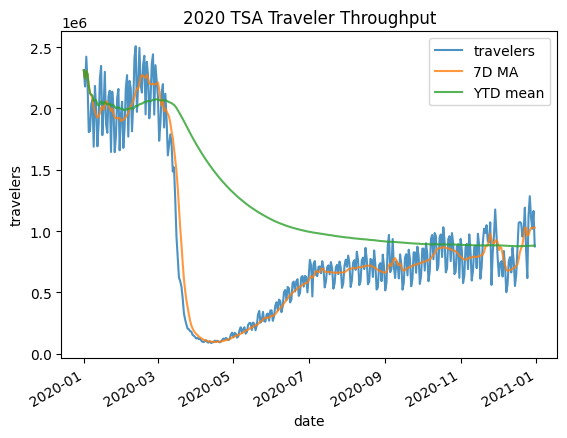

In [3]:
tsa_melted_holiday_travel.drop(columns='year').loc['2020'].assign(
    **{
        '7D MA': lambda x: x.travelers.rolling('7D').mean(),
        'YTD mean': lambda x: x.travelers.expanding().mean()
      }
).plot(title='2020 TSA Traveler Throughput', ylabel='travelers', alpha=0.8)

In [4]:
plot_data = tsa_melted_holiday_travel['2019':'2021-04']\
    .assign(month=lambda x: x.index.month)\
    .pivot_table(index='month', columns='year', values='travelers', aggfunc='sum')
plot_data.head()

year         2019        2020        2021
month                                    
1      59405722.0  61930286.0  23598230.0
2      57345684.0  60428859.0  24446345.0
3      72530252.0  32995003.0  38050060.0
4      70518994.0   3322548.0  41826159.0
5      74617773.0   7244733.0         NaN

In [5]:
import calendar
from matplotlib import ticker

ax = plot_data.plot(kind='bar', rot=0, xlabel='', ylabel='travelers',
                    figsize=(8, 1.5), title='TSA Monthly Traveler Throughput')

ax.set_xticklabels(calendar.month_abbr[1:]) # use month abbreviations for the ticks on the x-axis
ax.yaxis.set_major_formatter(ticker.EngFormatter()) # show y-axis labels in millions instead of scientific notation
ax.legend(title='', loc='center', bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False) # customize the legend

In [7]:
import matplotlib.pyplot as plt

In [8]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6, 4))

for year, ax in zip(tsa_melted_holiday_travel.year.unique(), axes):
    plot_data = tsa_melted_holiday_travel.loc[str(year)].travelers
    plot_data.plot(kind="hist", legend=False, density=True, alpha=0.8, ax=ax)
    plot_data.plot(kind="kde", legend=False, color="blue", alpha=0.7, ax=ax)
    ax.set(title=f"{year} TSA Traveler Throughput", xlabel="travelers")
           
fig.tight_layout()

In [9]:
import seaborn as sns

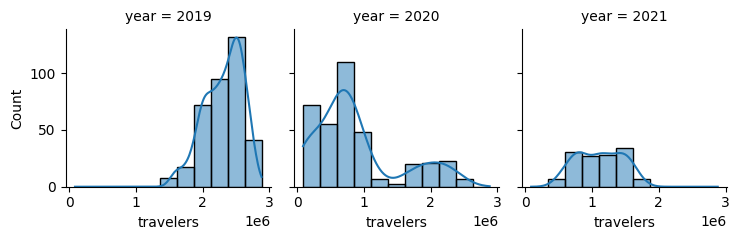

In [10]:
sns.displot(
    data=tsa_melted_holiday_travel, 
    x="travelers", 
    col="year", 
    kde=True, 
    height=2.5
)